# Imputación de valores perdidos


In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import plotly.graph_objects as go
from statsmodels.nonparametric.smoothers_lowess import lowess
from plotly.subplots import make_subplots
from scipy.stats import trim_mean

In [2]:
NUM_SERIES_ESTUDIO = 3 # Número de series temporales más representarivas que queremos visualizar
RANGE_VISUALIZ = [35.0, 38.0] # Rango de temperaturas para la visualización

fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h') # Para alinear las gráficas

In [3]:
# Cargamos los datos de las muestras de ovulación con valores entre [35.7, 37.7]
with open("../procData/muestras_ovul_suaviz.pkl", "rb") as f:
    muestras_ovul = pickle.load(f)

In [4]:
# Recogemos los nombres de las series temporales con las que trabajamos
name_series = muestras_ovul.keys()
num_series = len(name_series)
num_series

61

In [5]:
ids_series = [k for k, v in muestras_ovul.items()]

In [6]:
def imputar_faltantes_adaptativo(muestras_corregidas,
                                  ventana_contexto_base=80,
                                  suavizado_bordes_base=0,
                                  factor_lowess=0.3,
                                  proportiontocut_base=0.2,
                                  max_proportiontocut=0.4,
                                  min_valores_contexto=3):
    imputadas = {}

    for clave, entrada in muestras_corregidas.items():
        serie = entrada["serie"].copy()
        temps = serie["result"].copy()
        times = serie["resultTimestamp"]

        minutos = ((times - times.iloc[0]) / pd.Timedelta(minutes=1)).values
        temps_array = temps.values.astype(float)

        isnan = np.isnan(temps_array)
        cambios = np.diff(isnan.astype(int))
        inicios = np.where(cambios == 1)[0] + 1
        finales = np.where(cambios == -1)[0] + 1

        if isnan[0]:
            inicios = np.insert(inicios, 0, 0)
        if isnan[-1]:
            finales = np.append(finales, len(temps_array))

        mediana_global = np.nanmedian(temps_array)

        for inicio, fin in zip(inicios, finales):
            largo_tramo = fin - inicio
            factor = min(2.5, max(1.0, largo_tramo / 10))

            ventana_contexto = int((ventana_contexto_base * factor) // 2)
            suavizado_bordes = int((suavizado_bordes_base * factor) // 2)
            proportiontocut = min(max_proportiontocut, proportiontocut_base * factor)

            t_ini = minutos[inicio]
            t_fin = minutos[fin - 1]

            t_pre_ini = t_ini - ventana_contexto
            t_post_fin = t_fin + ventana_contexto

            idx_antes = (minutos >= t_pre_ini) & (minutos < t_ini) & (~np.isnan(temps_array))
            idx_despues = (minutos > t_fin) & (minutos <= t_post_fin) & (~np.isnan(temps_array))

            if np.sum(idx_antes) >= min_valores_contexto and np.sum(idx_despues) >= min_valores_contexto:
                media_antes = trim_mean(temps_array[idx_antes], proportiontocut=proportiontocut)
                media_despues = trim_mean(temps_array[idx_despues], proportiontocut=proportiontocut)
                valor_imputado = (media_antes + media_despues) / 2
            else:
                valor_imputado = mediana_global

            temps_array[inicio:fin] = valor_imputado

            # Suavizado en bordes con LOWESS
            for borde in [inicio, fin - 1]:
                idx_ini = max(0, borde - suavizado_bordes)
                idx_fin = min(len(temps_array), borde + suavizado_bordes)

                x_vals = minutos[idx_ini:idx_fin]
                y_vals = temps_array[idx_ini:idx_fin]

                mask_valid = ~np.isnan(y_vals)
                if np.sum(mask_valid) >= 5:
                    try:
                        y_suav = lowess(y_vals[mask_valid], x_vals[mask_valid], frac=factor_lowess, return_sorted=False)
                        j = 0
                        for k in range(idx_ini, idx_fin):
                            if not np.isnan(temps_array[k]):
                                temps_array[k] = y_suav[j]
                                j += 1
                    except Exception as e:
                        print(f"[WARN] LOWESS falló en {clave}, tramo {inicio}-{fin}: {e}")

        serie["result"] = temps_array
        imputadas[clave] = {
            "serie": serie,
            "ovul": entrada["ovul"]
        }

    return imputadas


In [7]:
muestras_imputadas = imputar_faltantes_adaptativo(muestras_ovul)

In [8]:
# print_series_zoom
# Tiene dos modos de mostrar cada serie original y corregida: solapadas o separadas

def print_series_zoom(muestras_orig, muestras_corr, list_ids, modo_visualizacion='solapadas'):

    fecha_ref = pd.Timestamp('2025-01-01 00:00:00').floor('h')

    for id in list_ids:
        serie_orig = muestras_orig[id]["serie"]
        serie_corr = muestras_corr[id]["serie"]

        x_orig = (serie_orig["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_orig = serie_orig["result"]
        x_corr = (serie_corr["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y_corr = serie_corr["result"]

        if modo_visualizacion == 'solapadas':
            fig = go.Figure()

            fig.add_trace(go.Scatter(
                x=x_orig,
                y=y_orig,
                mode='markers',
                name=f'{id} (original)',
                marker=dict(size=4, color='blue'),
                opacity=0.5
            ))

            fig.add_trace(go.Scatter(
                x=x_corr,
                y=y_corr,
                mode='markers',
                name=f'{id} (corregida)',
                marker=dict(size=4, color='green')
            ))

            fig.add_shape(
                type="line", x0=0, x1=0, y0=35.5, y1=37.7,
                line=dict(color="red", width=2, dash="dash")
            )
            fig.add_annotation(
                x=0, y=37.7, text="Ovulación", showarrow=False,
                yanchor="bottom", font=dict(color="red")
            )

            fig.update_layout(
                title=f"Serie {id}: Original vs Corregida",
                xaxis_title="Día relativo a la ovulación",
                yaxis_title="Temperatura (°C)",
                hovermode="x unified",
                template="plotly_white",
                height=400
            )
            fig.update_yaxes(range=RANGE_VISUALIZ)

        elif modo_visualizacion == 'separadas':
            fig = make_subplots(rows=2, cols=1,
                                shared_xaxes=True,
                                subplot_titles=[f"{id} (original)", f"{id} (corregida)"],
                                vertical_spacing=0.1)

            fig.add_trace(go.Scatter(
                x=x_orig,
                y=y_orig,
                mode='markers',
                name='Original',
                marker=dict(size=4, color='blue'),
                opacity=0.6
            ), row=1, col=1)

            fig.add_trace(go.Scatter(
                x=x_corr,
                y=y_corr,
                mode='markers',
                name='Corregida',
                marker=dict(size=4, color='green')
            ), row=2, col=1)

            # Línea de ovulación en ambas subgráficas
            for row in [1, 2]:
                fig.add_shape(
                    type="line", x0=0, x1=0, y0=35.5, y1=37.7,
                    line=dict(color="red", width=2, dash="dash"),
                    row=row, col=1
                )
                fig.add_annotation(
                    x=0, y=37.7, text="Ovulación", showarrow=False,
                    yanchor="bottom", font=dict(color="red"),
                    row=row, col=1
                )

            fig.update_layout(
                title_text=f"Serie {id}: Original y Corregida",
                height=600,
                template="plotly_white",
                hovermode="x unified"
            )
            fig.update_yaxes(range=RANGE_VISUALIZ, row=1, col=1)
            fig.update_yaxes(range=RANGE_VISUALIZ, row=2, col=1)
            fig.update_xaxes(title_text="Día relativo a la ovulación", row=2, col=1)
            fig.update_yaxes(title_text="Temperatura (°C)", row=1, col=1)
            fig.update_yaxes(title_text="Temperatura (°C)", row=2, col=1)

        else:
            raise ValueError("El parámetro 'modo_visualizacion' debe ser 'solapadas' o 'separadas'.")
        
        fig.show()

In [9]:
# print_series
# Función para mostrar gráficamente las series temporales de list_ids con matplotlib
def print_series(list_ids, muestras):

    for id in list_ids:
        serie = muestras[id]["serie"]

        # Convertimos las fechas a días relativos a la ovulación
        x = (serie["resultTimestamp"] - fecha_ref) / pd.Timedelta(days=1)
        y = serie["result"]

        plt.figure(figsize=(8, 4))

        # Puntos de la serie
        plt.scatter(x, y, s=5, label=f'Serie {id}', alpha=0.8)

        # Línea vertical discontinua en el día 0 (ovulación)
        plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
        #plt.text(0, 38.7, 'Ovulación', color='red', ha='center', va='bottom')

        # Etiquetas y título
        plt.title(f'Serie {id}')
        plt.xlabel('Día relativo a la ovulación')
        plt.ylabel('Temperatura (°C)')
        plt.grid(True)

        plt.ylim(RANGE_VISUALIZ[0], RANGE_VISUALIZ[1])  

        plt.tight_layout()
        plt.show()

In [ ]:
print_series_zoom(muestras_orig=muestras_ovul, muestras_corr=muestras_imputadas, list_ids=ids_series[:NUM_SERIES_ESTUDIO], modo_visualizacion="separadas")

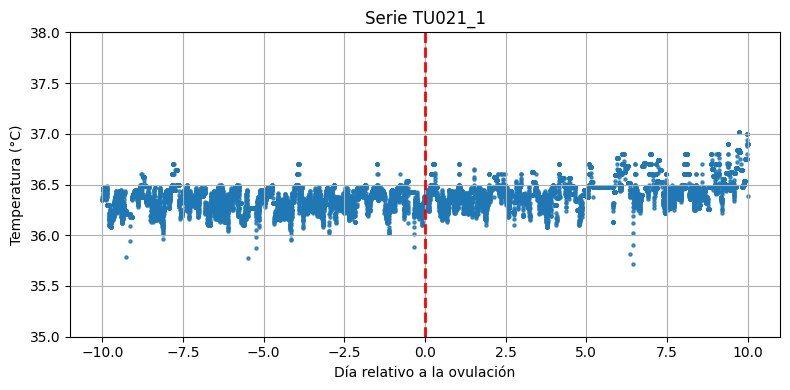

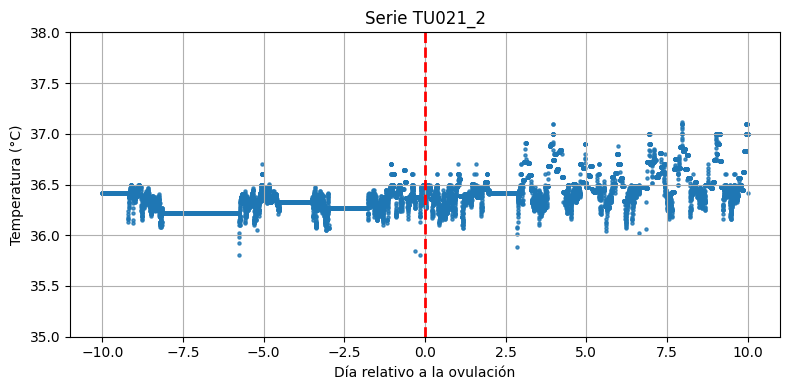

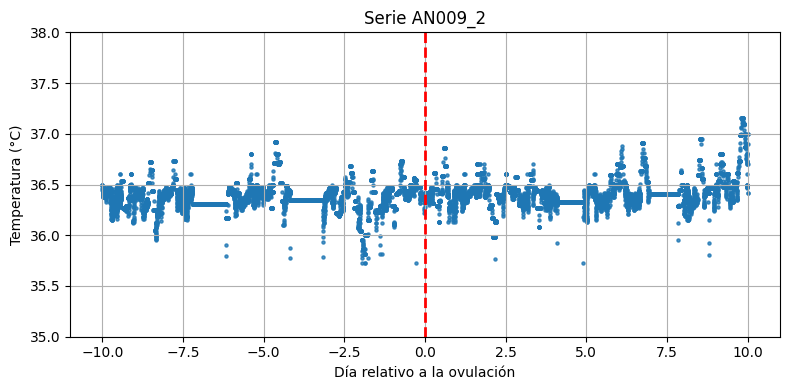

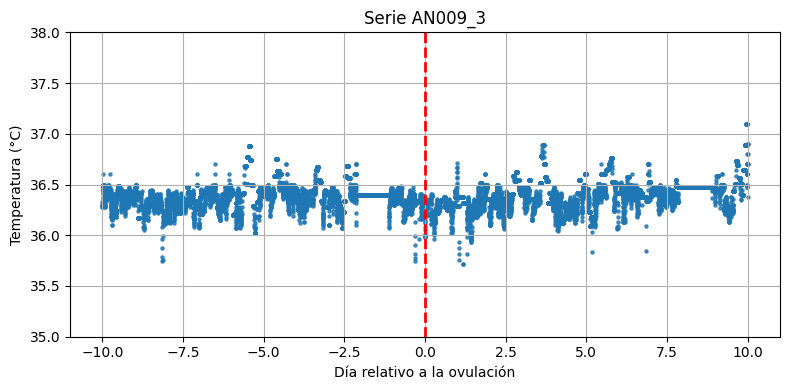

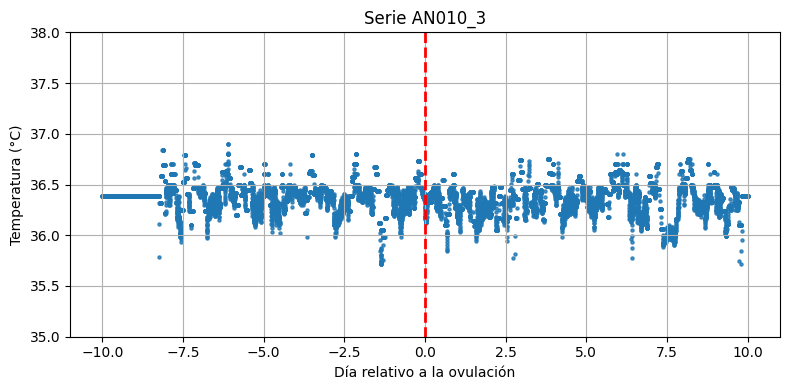

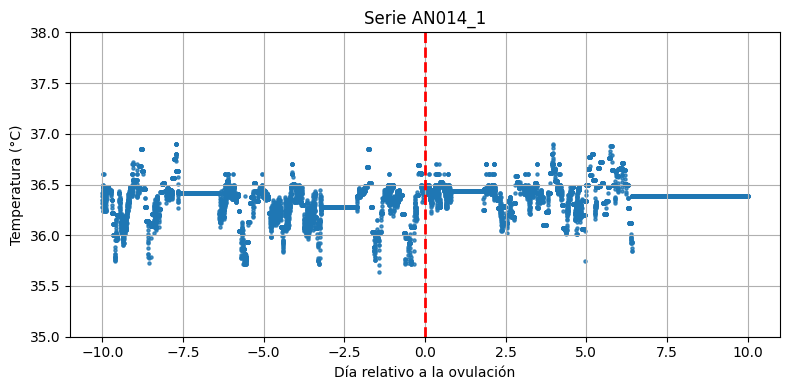

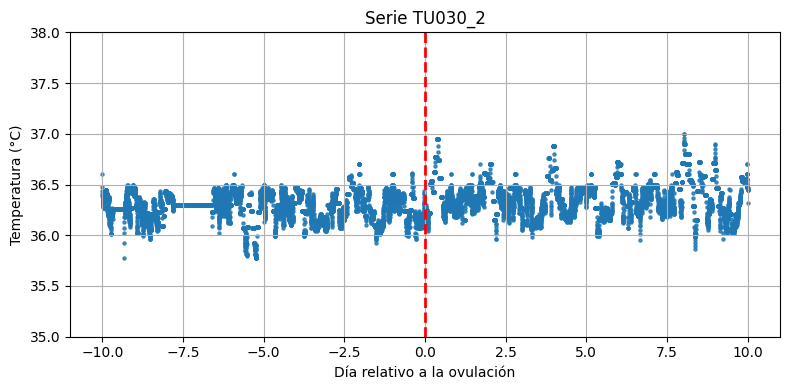

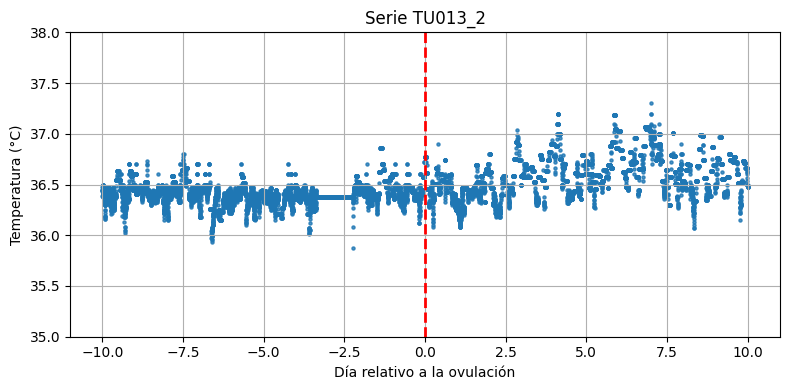

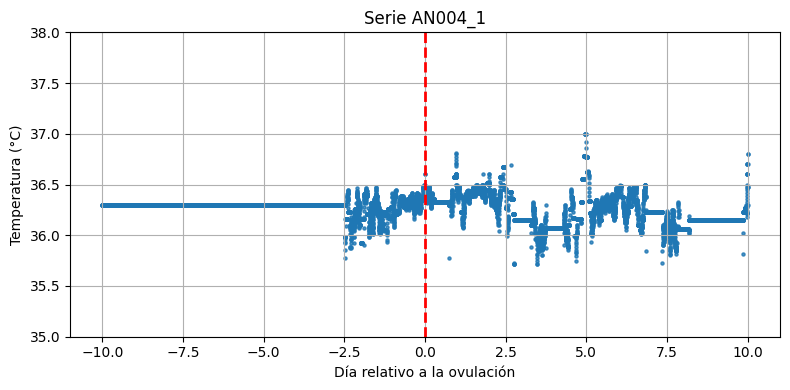

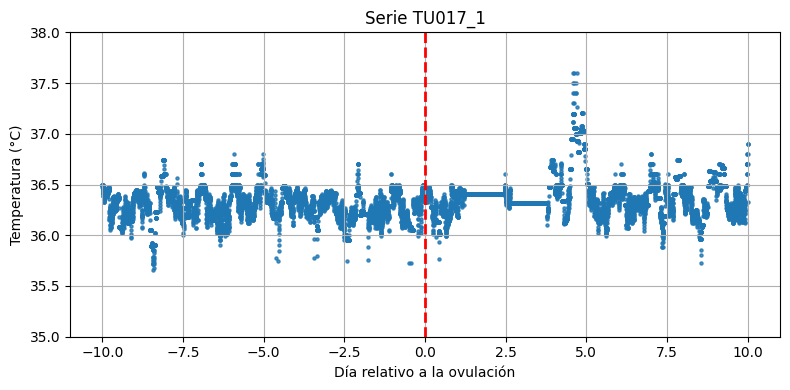

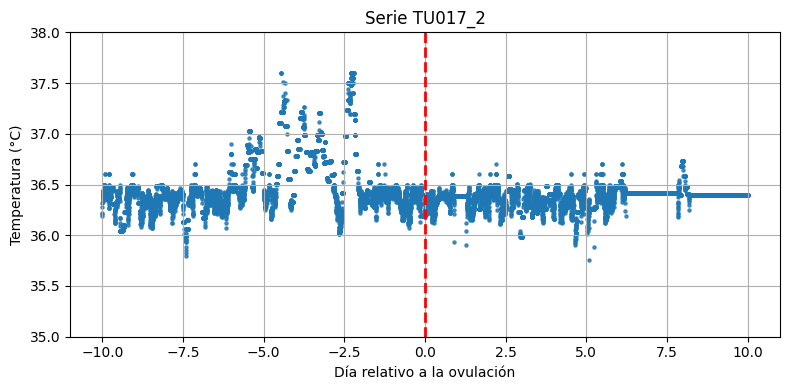

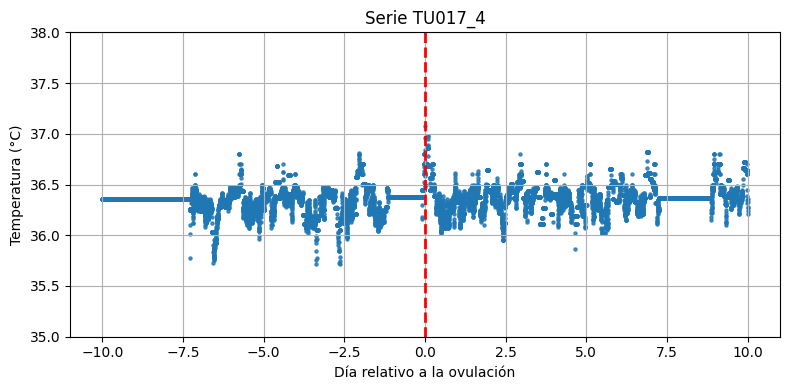

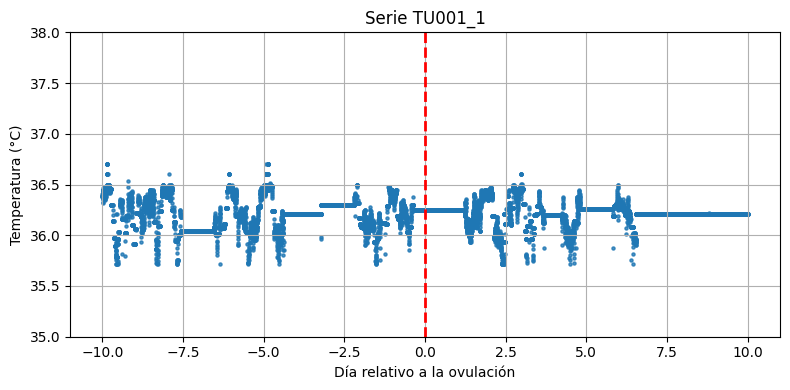

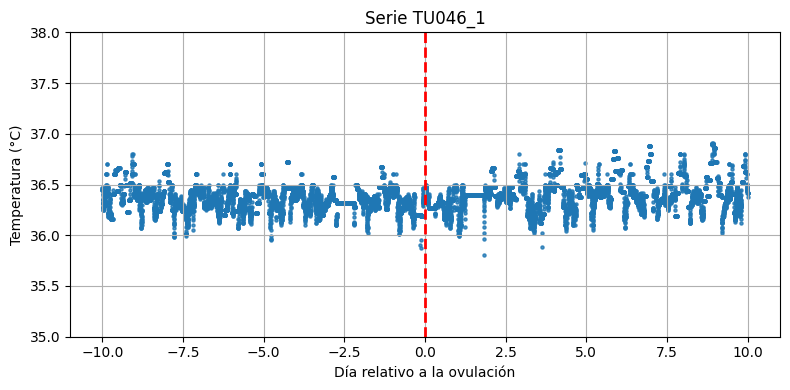

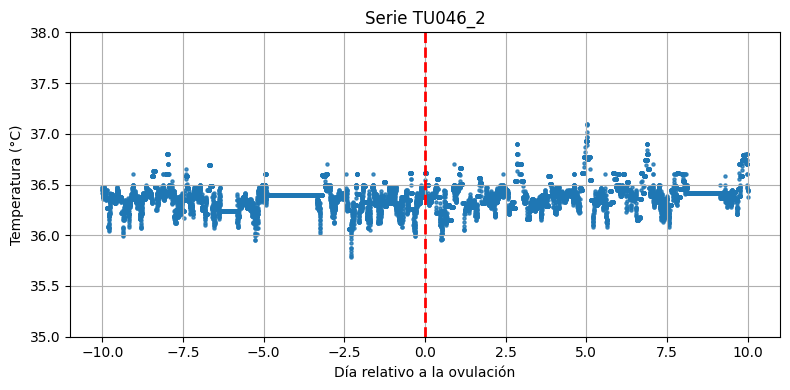

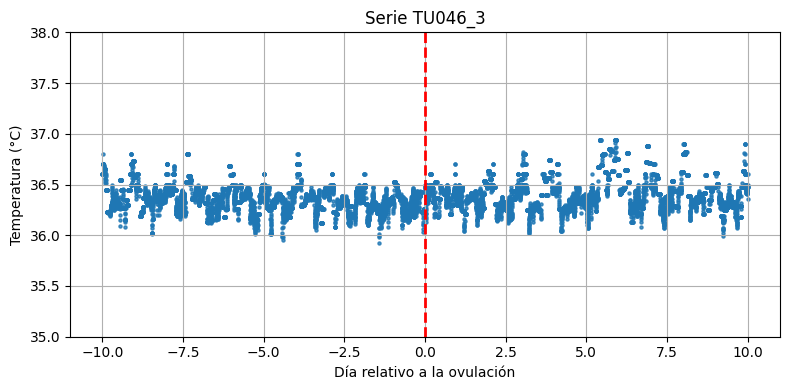

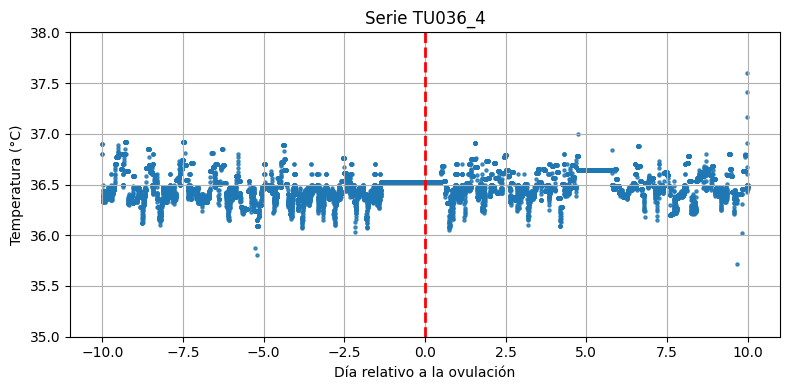

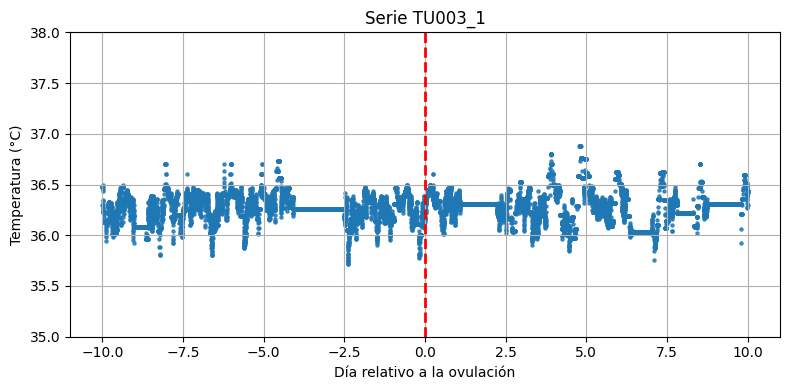

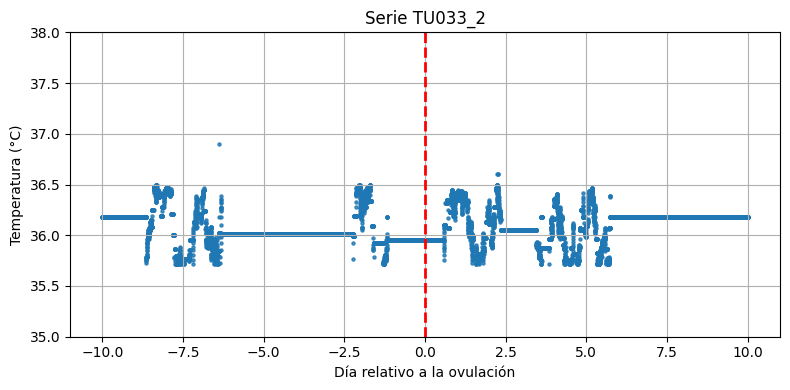

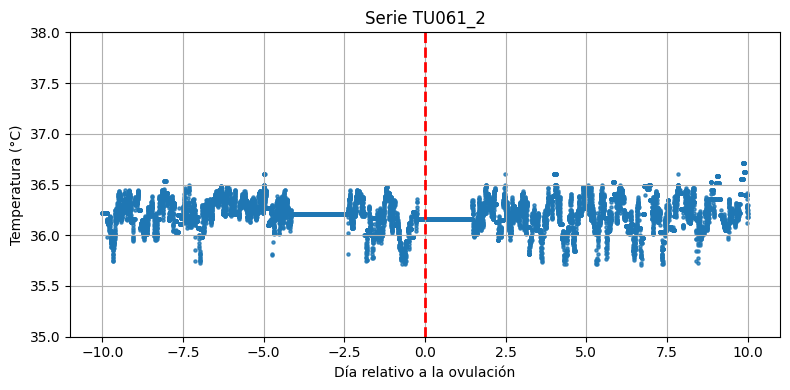

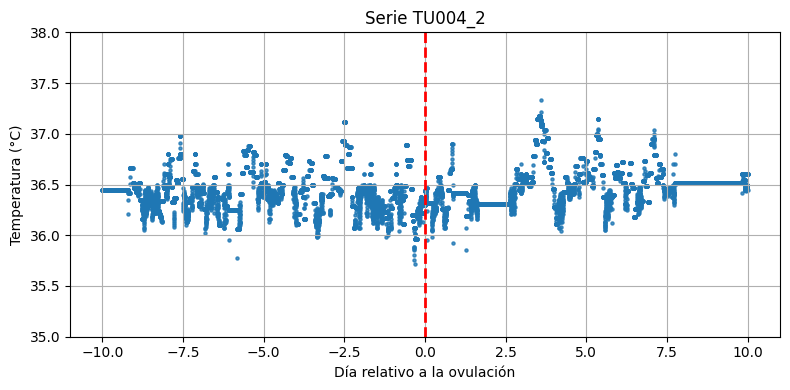

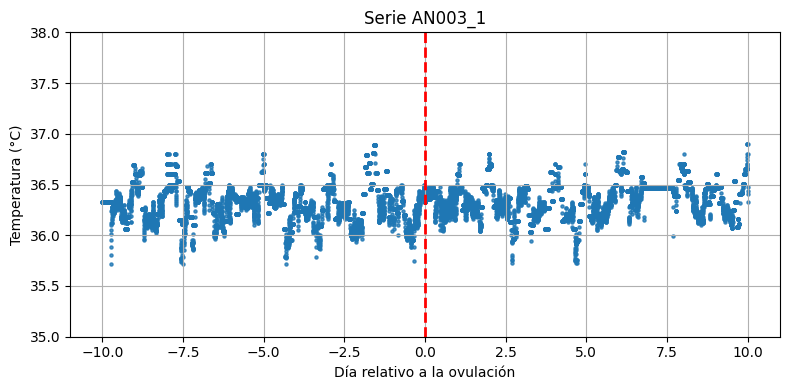

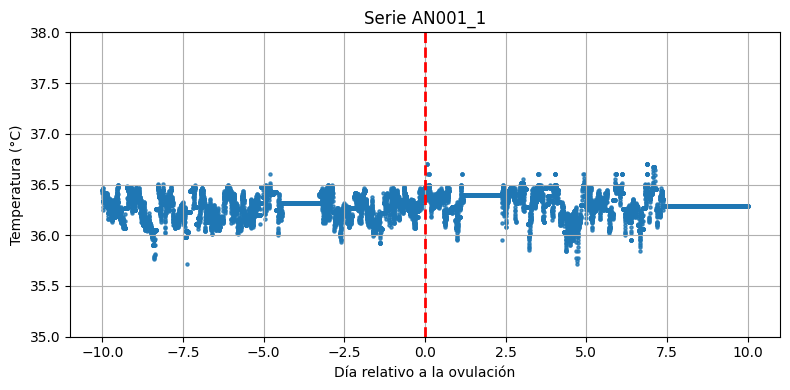

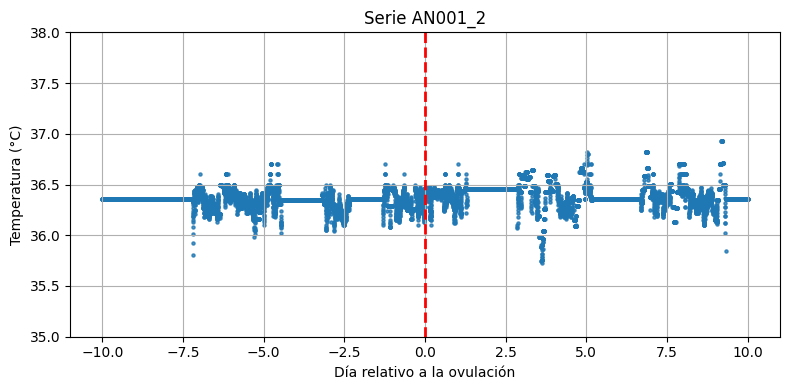

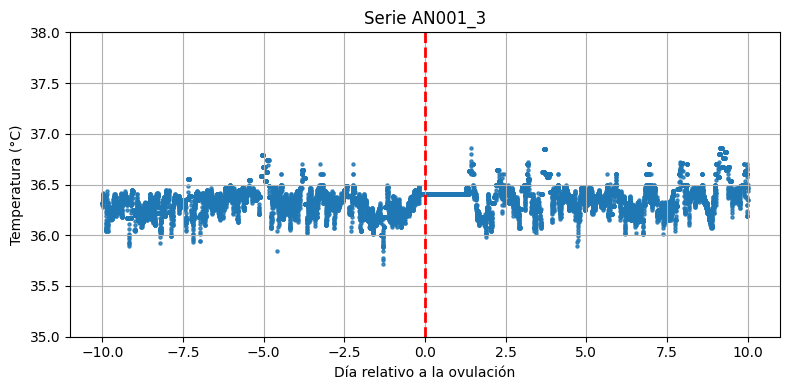

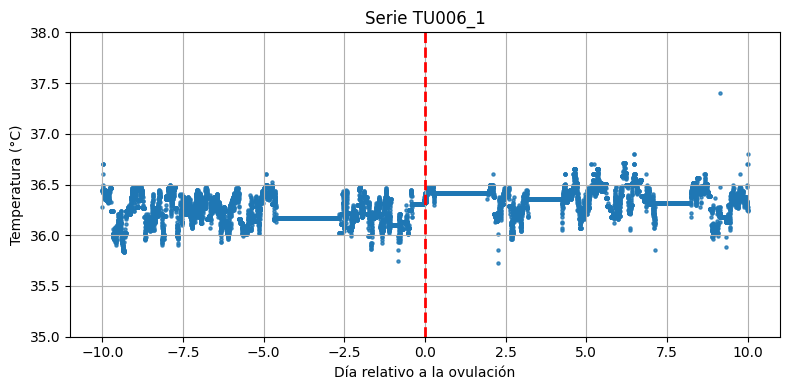

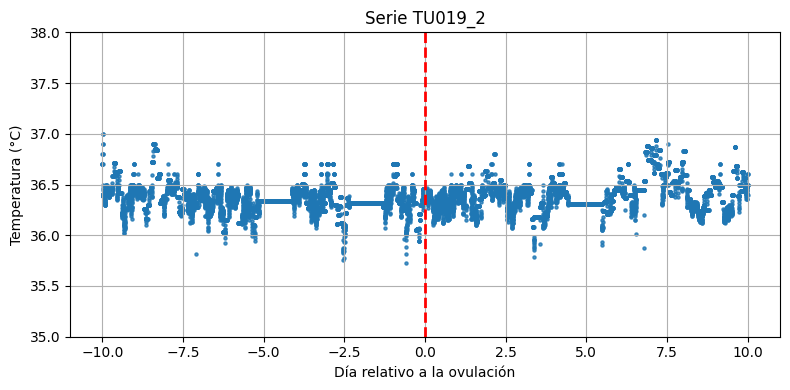

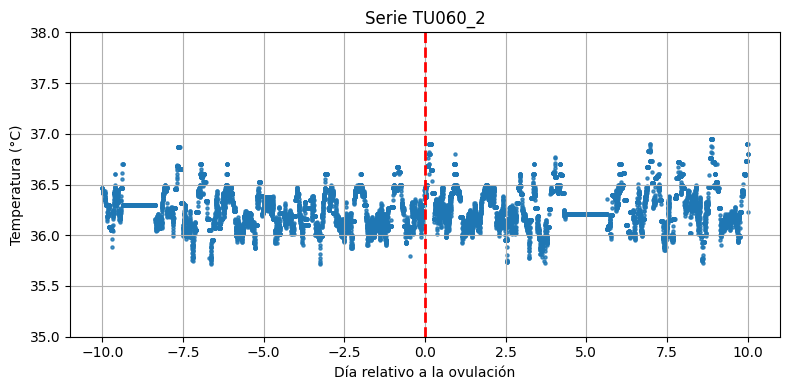

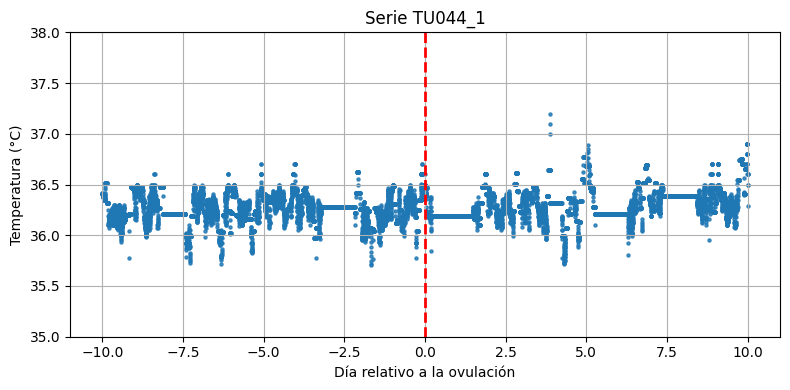

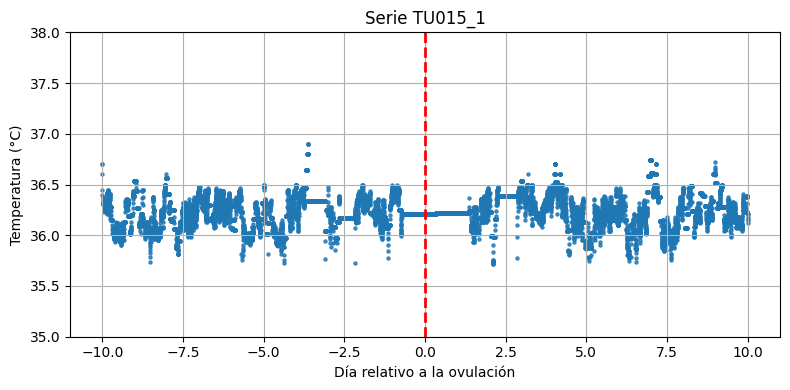

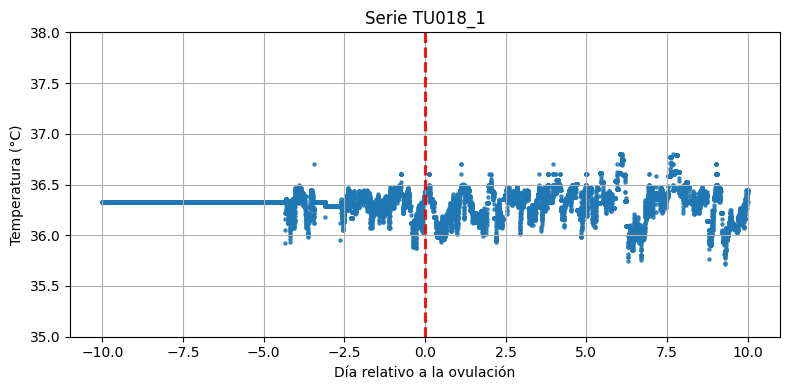

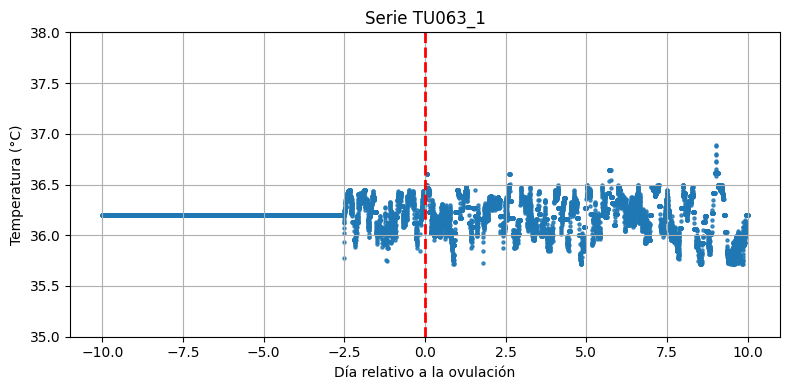

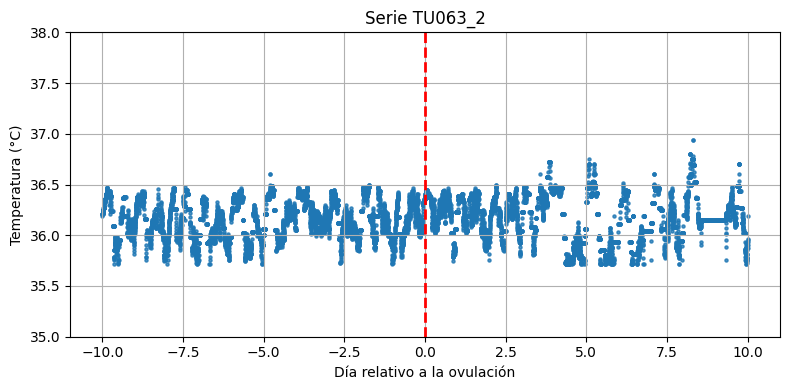

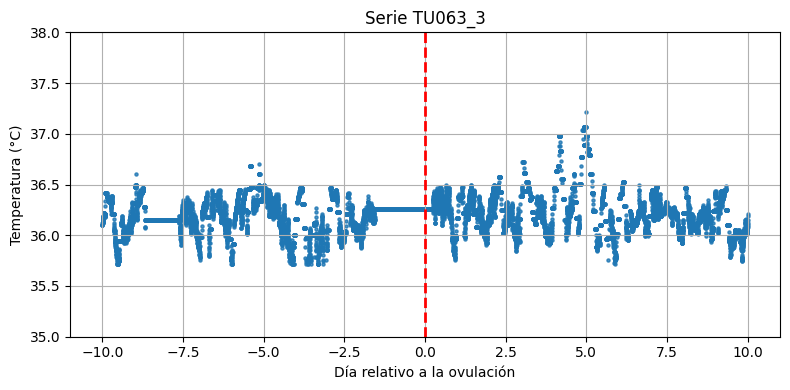

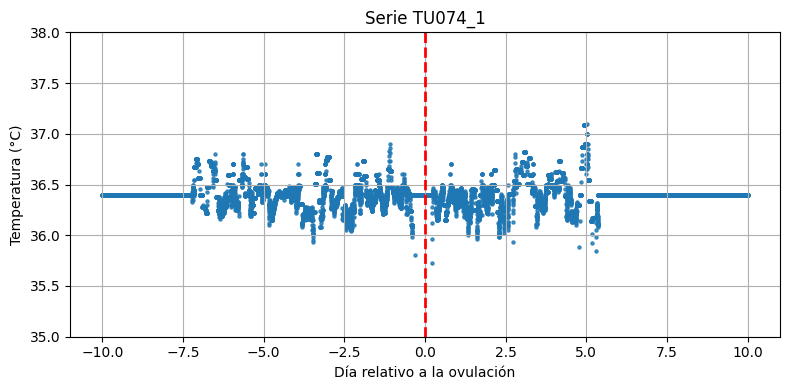

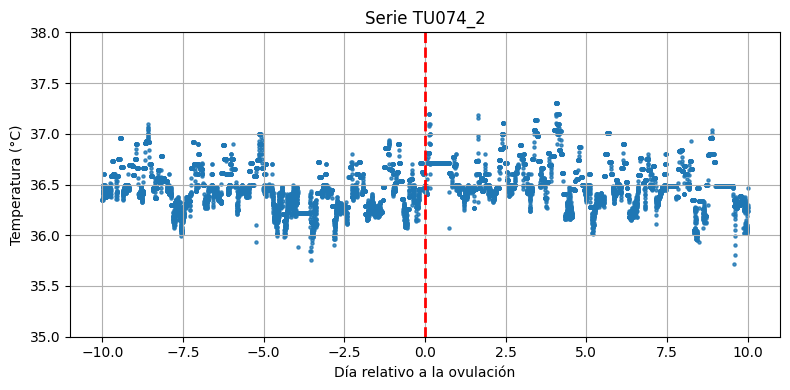

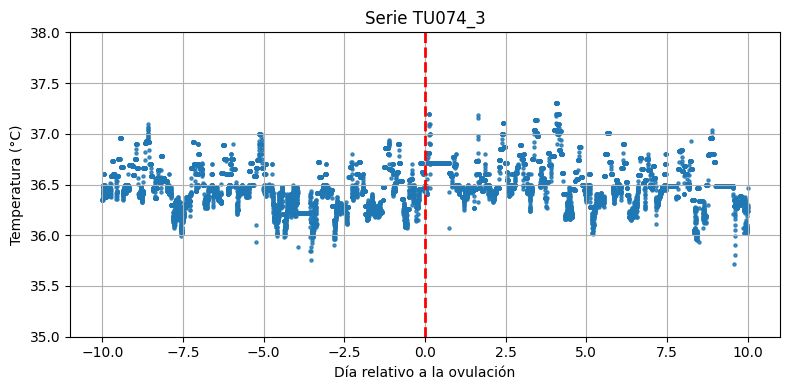

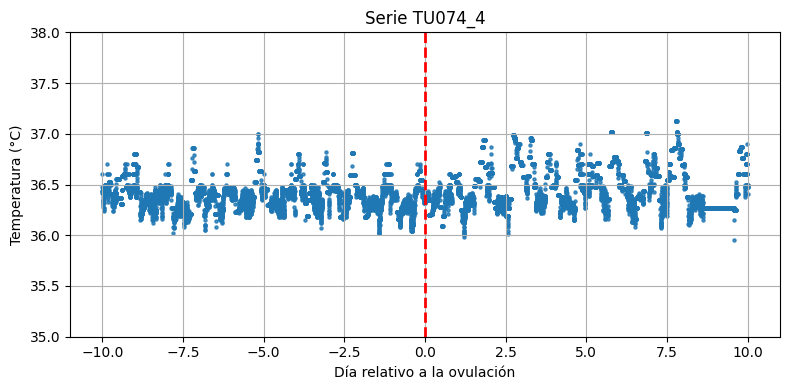

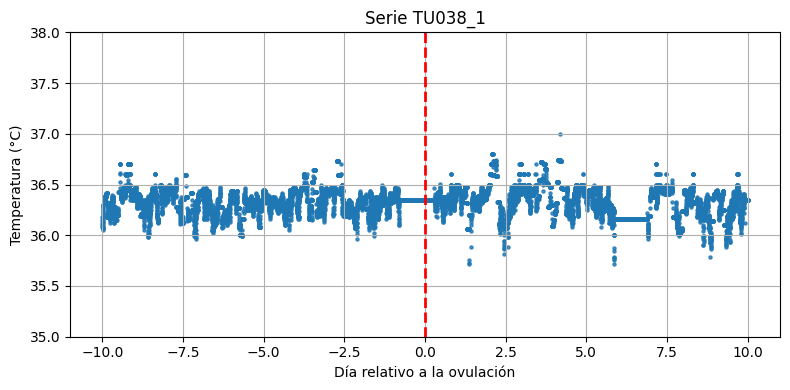

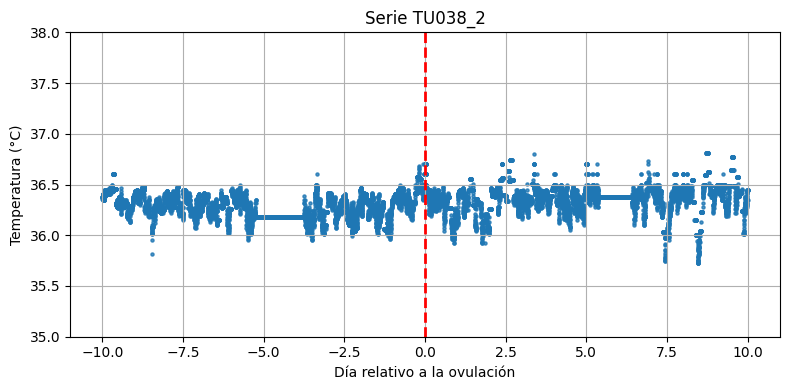

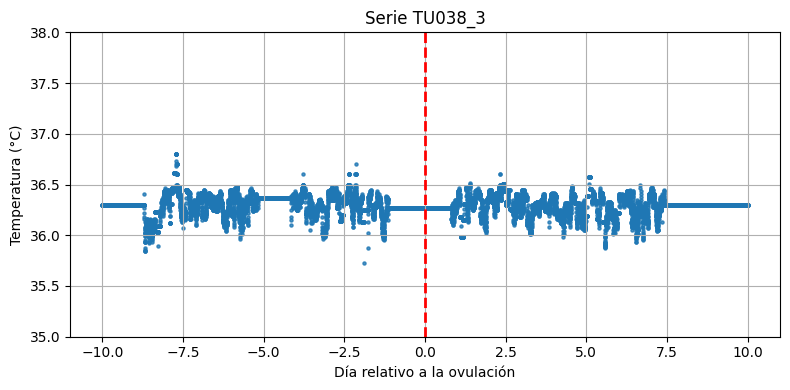

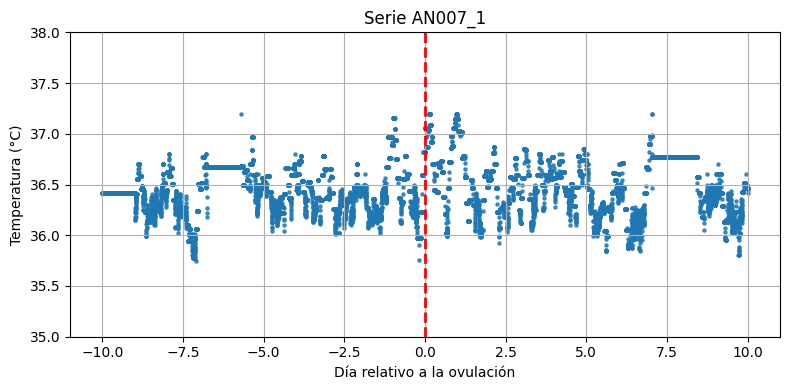

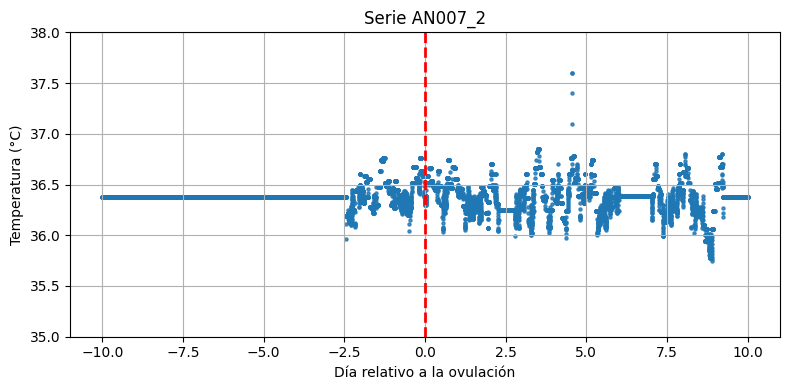

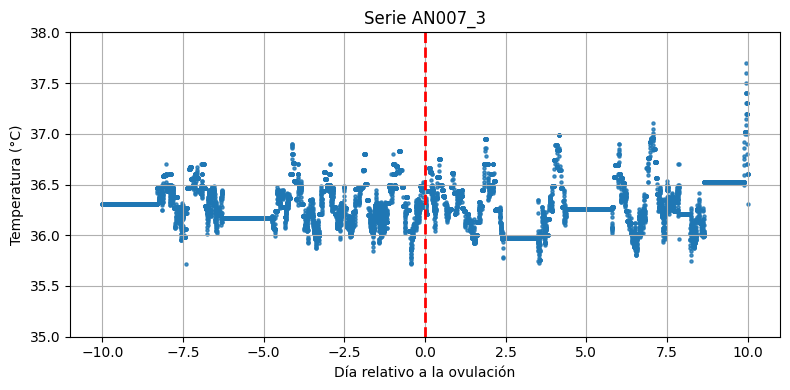

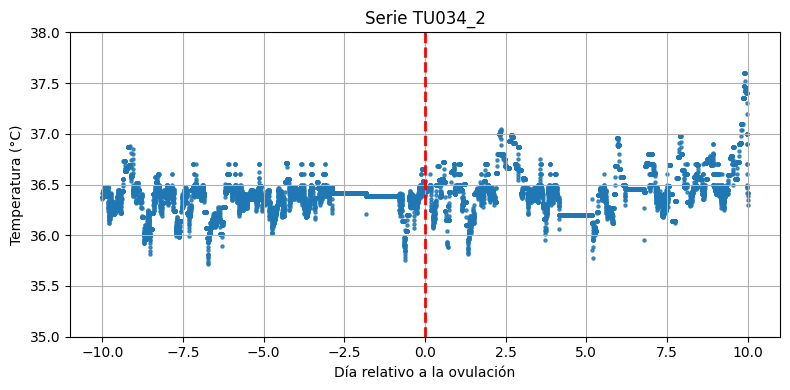

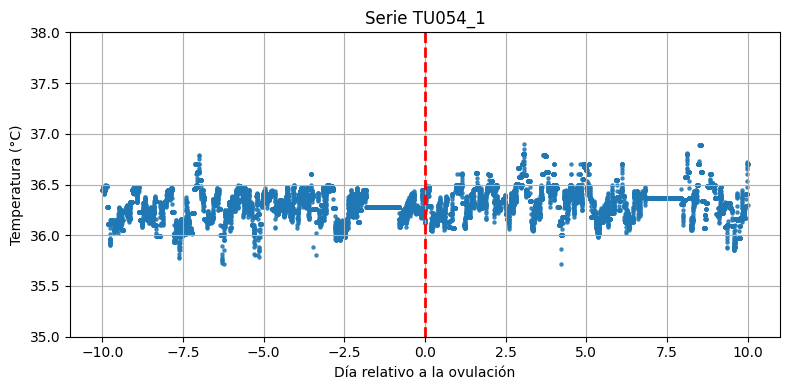

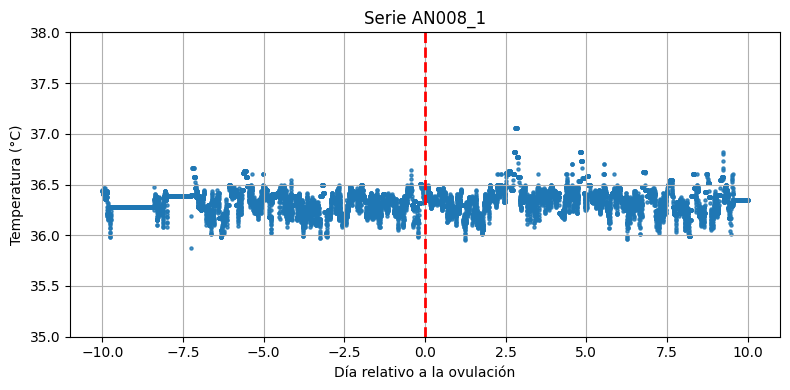

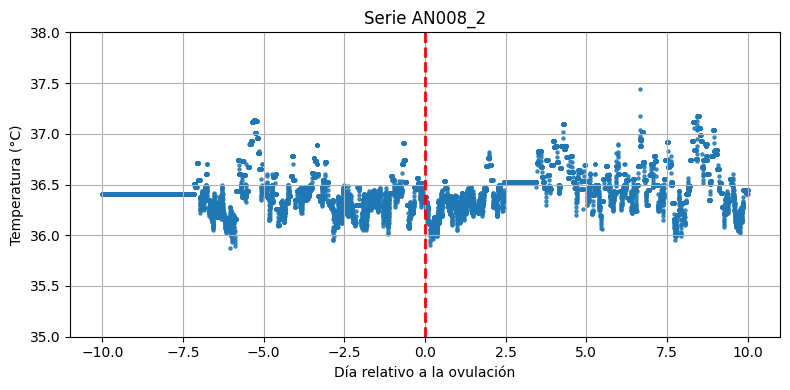

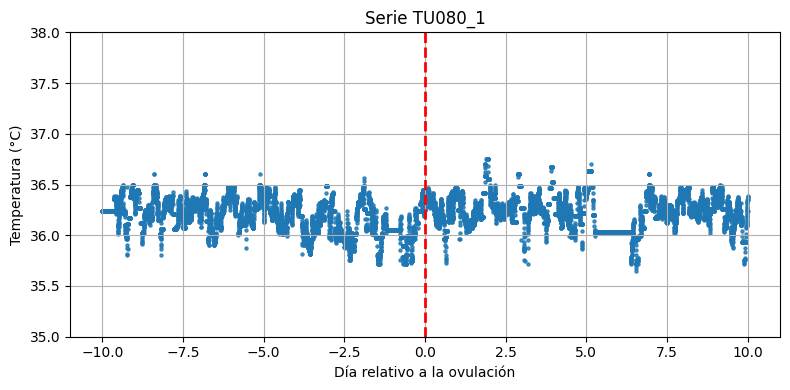

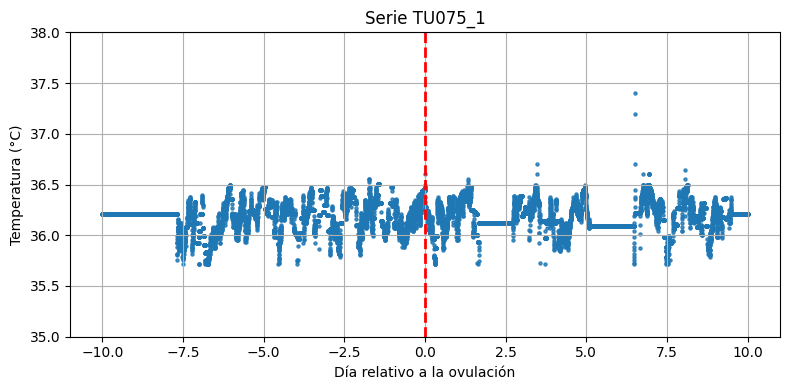

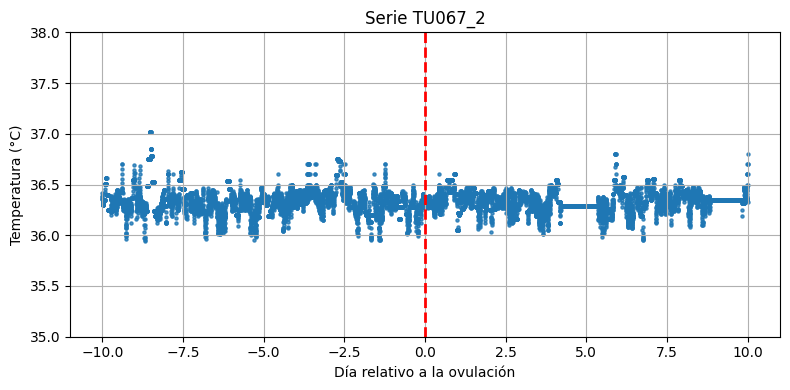

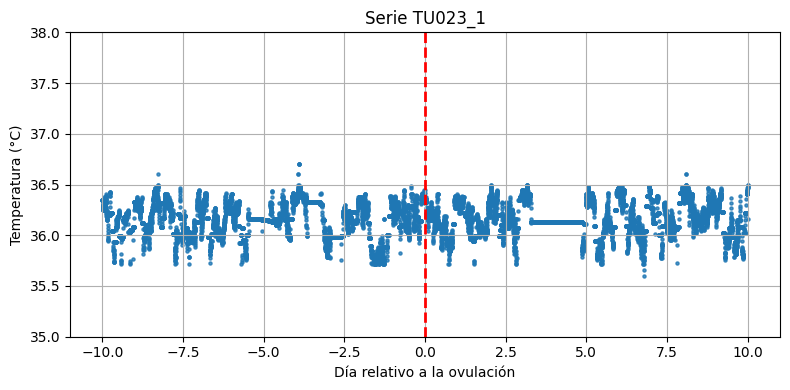

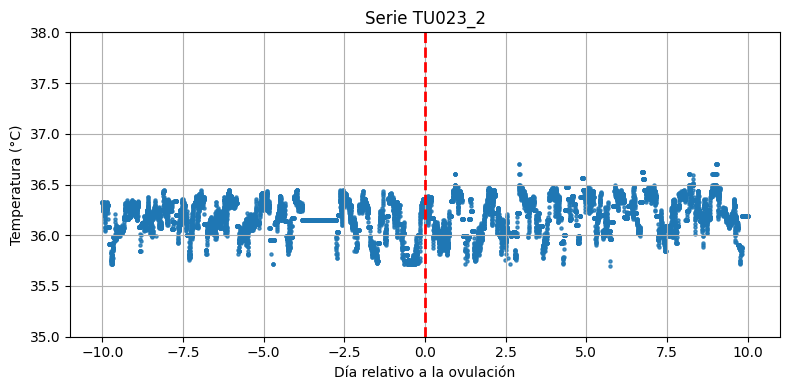

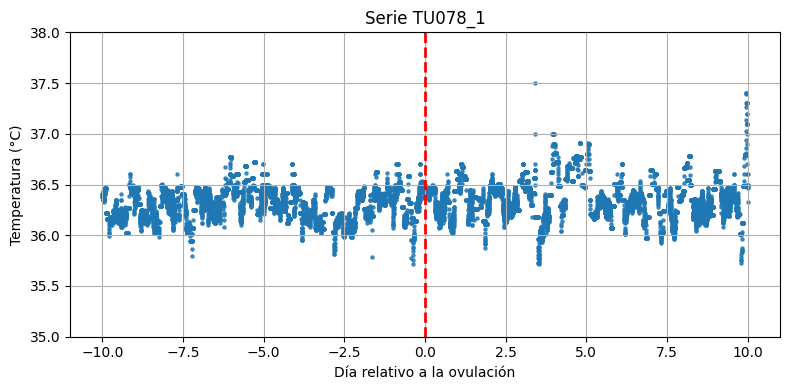

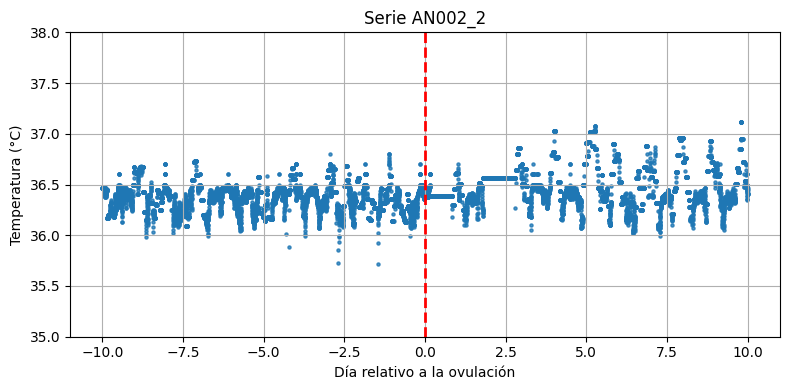

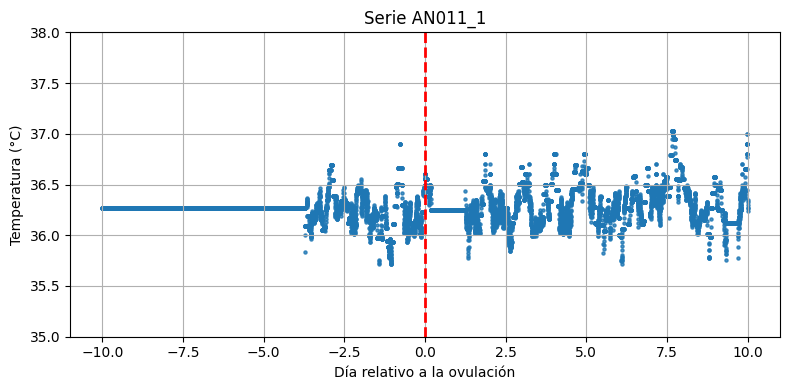

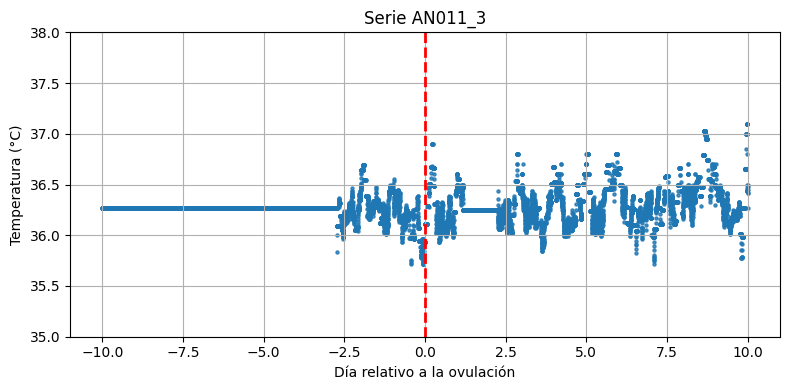

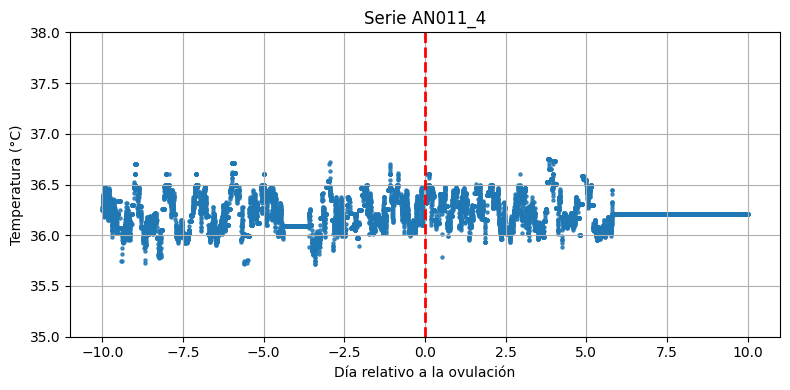

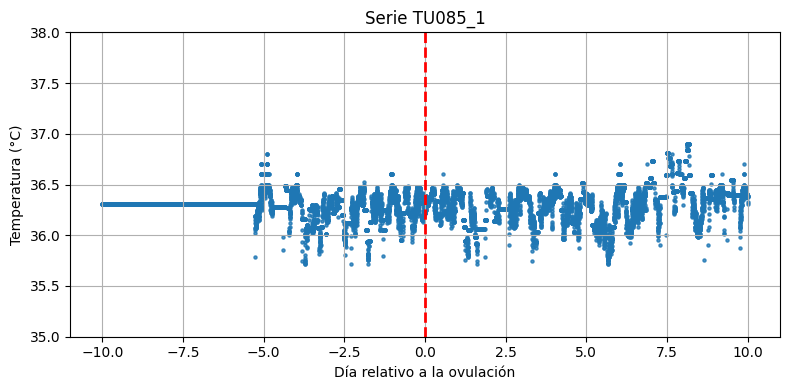

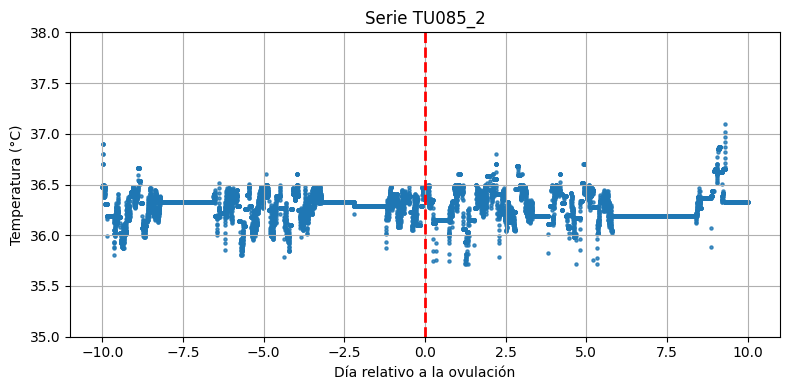

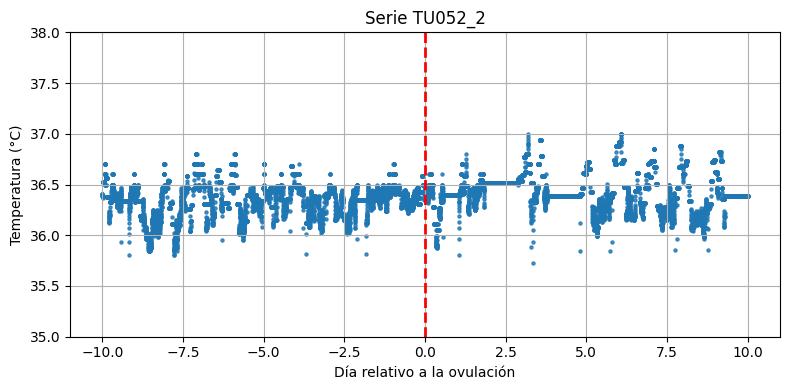

In [10]:
print_series(ids_series, muestras_imputadas)

In [11]:
# Crear una lista con (id, número de valores no nulos)
numero_no_nulos = [
    (k, v["serie"]["result"].isna().sum()) for k, v in muestras_imputadas.items()
]

# Ordenar de mayor a menor cantidad de valores no nulos
numero_no_nulos.sort(key=lambda x: x[1], reverse=True)

numero_no_nulos

[('TU021_1', np.int64(0)),
 ('TU021_2', np.int64(0)),
 ('AN009_2', np.int64(0)),
 ('AN009_3', np.int64(0)),
 ('AN010_3', np.int64(0)),
 ('AN014_1', np.int64(0)),
 ('TU030_2', np.int64(0)),
 ('TU013_2', np.int64(0)),
 ('AN004_1', np.int64(0)),
 ('TU017_1', np.int64(0)),
 ('TU017_2', np.int64(0)),
 ('TU017_4', np.int64(0)),
 ('TU001_1', np.int64(0)),
 ('TU046_1', np.int64(0)),
 ('TU046_2', np.int64(0)),
 ('TU046_3', np.int64(0)),
 ('TU036_4', np.int64(0)),
 ('TU003_1', np.int64(0)),
 ('TU033_2', np.int64(0)),
 ('TU061_2', np.int64(0)),
 ('TU004_2', np.int64(0)),
 ('AN003_1', np.int64(0)),
 ('AN001_1', np.int64(0)),
 ('AN001_2', np.int64(0)),
 ('AN001_3', np.int64(0)),
 ('TU006_1', np.int64(0)),
 ('TU019_2', np.int64(0)),
 ('TU060_2', np.int64(0)),
 ('TU044_1', np.int64(0)),
 ('TU015_1', np.int64(0)),
 ('TU018_1', np.int64(0)),
 ('TU063_1', np.int64(0)),
 ('TU063_2', np.int64(0)),
 ('TU063_3', np.int64(0)),
 ('TU074_1', np.int64(0)),
 ('TU074_2', np.int64(0)),
 ('TU074_3', np.int64(0)),
 

In [12]:
def corregir_series(muestras_ovul, umbral_cambio=0.3, factor_lowess=0.5,
                    ventana_estudio=60, ventana_antes=30, ventana_despues=30, 
                    ampliar_correccion = 0, suavizado_lateral=20):  # Todo en minutos

    muestras_corregidas = {}

    # Los timestamps son cada dos minutos:
    ventana_estudio = ventana_estudio // 2
    ventana_antes = ventana_antes // 2
    ventana_despues = ventana_despues // 2
    ampliar_correccion = ampliar_correccion // 2
    suavizado_lateral = suavizado_lateral // 2

    for clave, entrada in muestras_ovul.items():
        serie = entrada["serie"].copy()
        serie = serie.sort_values("resultTimestamp").reset_index(drop=True)

        temps = serie["result"].copy()
        times = serie["resultTimestamp"]

        minutos = ((times - times.iloc[0]) / pd.Timedelta(minutes=1)).values
        temps_array = temps.values.astype('float64')

        i = ventana_antes + ventana_estudio // 2

        while i < len(temps_array) - (ventana_despues + ventana_estudio // 2):
            if np.isnan(temps_array[i]):
                i += 1
                continue

            # Índices de ventanas
            idx_ventana_antes = np.arange(i - (ventana_antes + ventana_estudio // 2), i - ventana_estudio // 2)
            idx_ventana_antes = [idx for idx in idx_ventana_antes if not np.isnan(temps_array[idx])]
            if len(idx_ventana_antes) < 5:
                i += 1
                continue

            idx_ventana_despues = np.arange(i + ventana_estudio // 2, i + ventana_despues + ventana_estudio // 2)
            idx_ventana_despues = [idx for idx in idx_ventana_despues if not np.isnan(temps_array[idx])]
            if len(idx_ventana_despues) < 5:
                i += 1
                continue

            idx_ventana_estudio = np.arange(i - ventana_estudio // 2, i + ventana_estudio // 2)
            idx_ventana_estudio = [idx for idx in idx_ventana_estudio if not np.isnan(temps_array[idx])]
            if len(idx_ventana_estudio) < 5:
                i += 1
                continue

            # Estadísticas de comparación
            media_antes = np.mean([temps_array[idx] for idx in idx_ventana_antes])
            media_despues = np.mean([temps_array[idx] for idx in idx_ventana_despues])
            min_ventana = np.min([temps_array[idx] for idx in idx_ventana_estudio])
            max_ventana = np.max([temps_array[idx] for idx in idx_ventana_estudio])

            diferencia_antes = max(abs(media_antes - min_ventana), abs(media_antes - max_ventana))
            diferencia_despues = max(abs(media_despues - min_ventana), abs(media_despues - max_ventana))

            if (diferencia_antes > umbral_cambio) and (diferencia_despues > umbral_cambio):
                # Aplanar usando media de ambos lados
                idx_inicio = max(0, i - ventana_estudio // 2 - ampliar_correccion)
                idx_fin = min(len(temps_array), i + ventana_estudio // 2 + ampliar_correccion)
                idx_aplanado = np.arange(idx_inicio, idx_fin)
                idx_aplanado = [idx for idx in idx_aplanado if not np.isnan(temps_array[idx])]

                media_aplanado = (media_antes + media_despues) / 2
                for idx in idx_aplanado:
                    temps_array[idx] = media_aplanado

                # Suavizado en los bordes con LOWESS
                suavizar_margen = suavizado_lateral // 2

                for borde in [idx_inicio, idx_fin - 1]:
                    idx_borde_ini = max(0, borde - suavizar_margen)
                    idx_borde_fin = min(len(temps_array), borde + suavizar_margen)
                    x_borde = minutos[idx_borde_ini:idx_borde_fin]
                    y_borde = temps_array[idx_borde_ini:idx_borde_fin]

                    mask_valid_borde = ~np.isnan(y_borde)
                    x_valid = x_borde[mask_valid_borde]
                    y_valid = y_borde[mask_valid_borde]

                    if len(y_valid) >= 5:
                        try:
                            y_suav = lowess(y_valid, x_valid, frac=factor_lowess, return_sorted=False)
                            j = 0
                            for k in range(idx_borde_ini, idx_borde_fin):
                                if not np.isnan(temps_array[k]):
                                    temps_array[k] = y_suav[j]
                                    j += 1
                        except Exception as e:
                            print(f"[WARN] Error LOWESS en borde {clave}, índice {borde}: {e}")

                i += ventana_estudio
            else:
                i += 1

        serie["result"] = temps_array
        muestras_corregidas[clave] = {
            "serie": serie,
            "ovul": entrada["ovul"]
        }

    return muestras_corregidas


In [13]:
muestras_imputadas_suavizadas = corregir_series(muestras_imputadas)

In [14]:
with open("../procData/muestras_ovul_imput.pkl", "wb") as f:
    pickle.dump(muestras_imputadas_suavizadas, f)

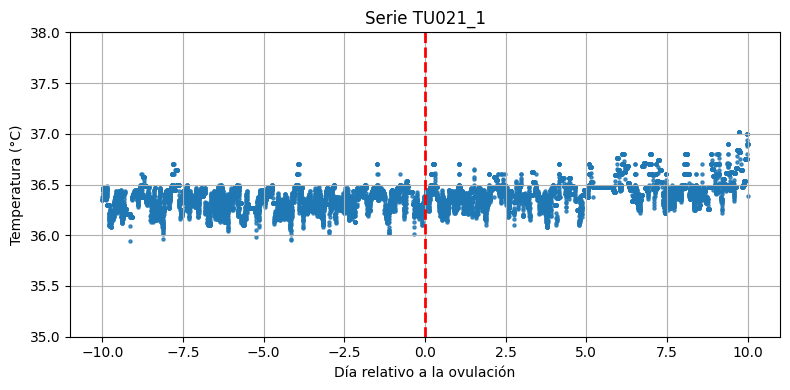

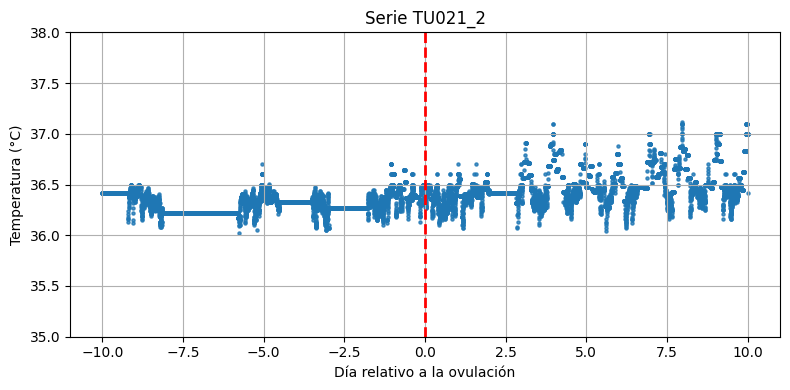

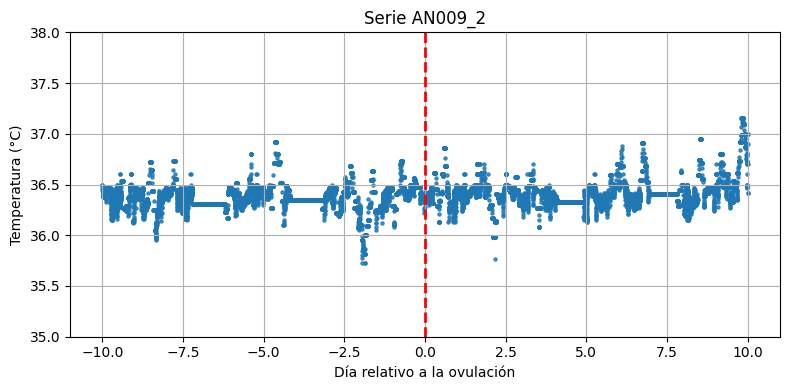

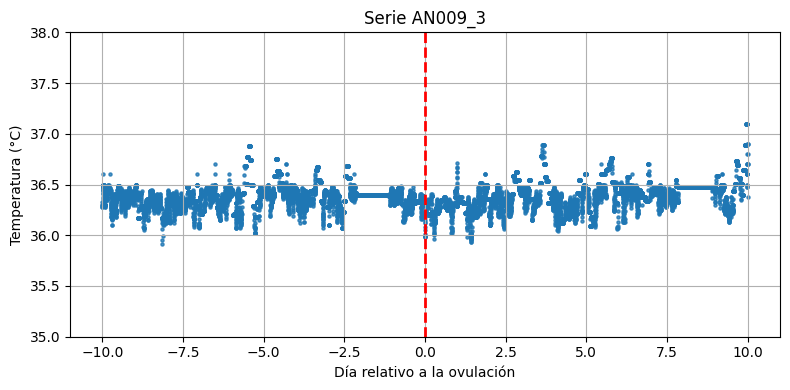

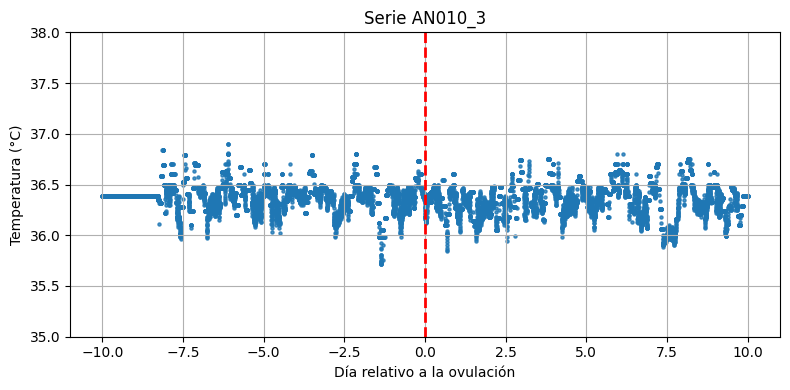

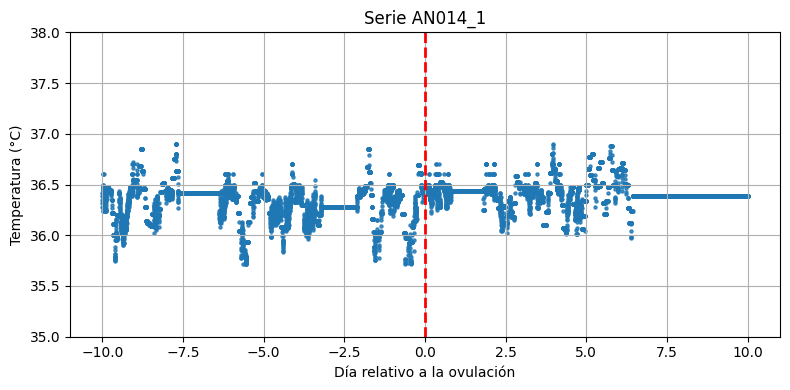

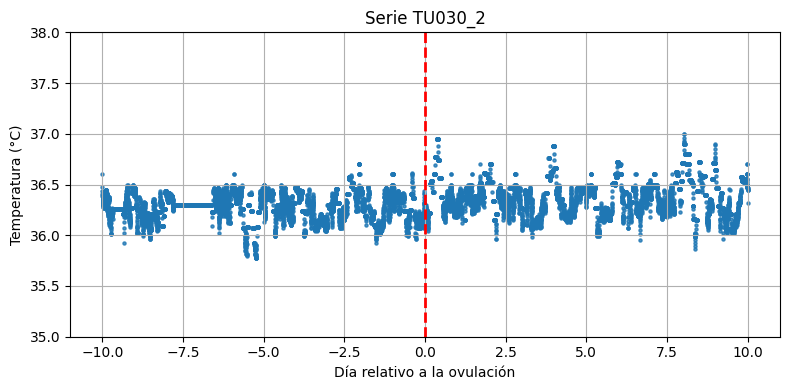

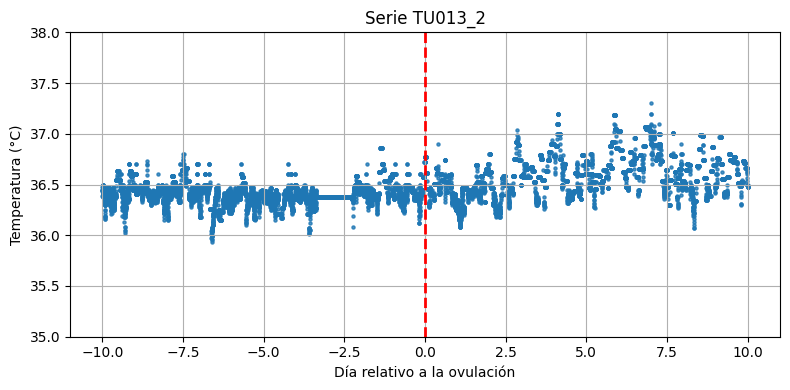

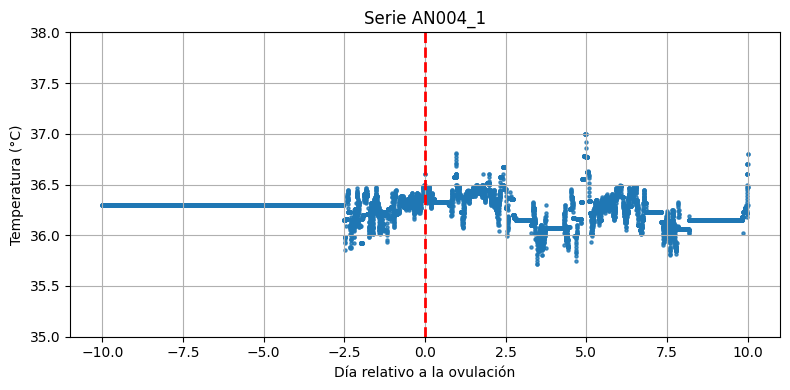

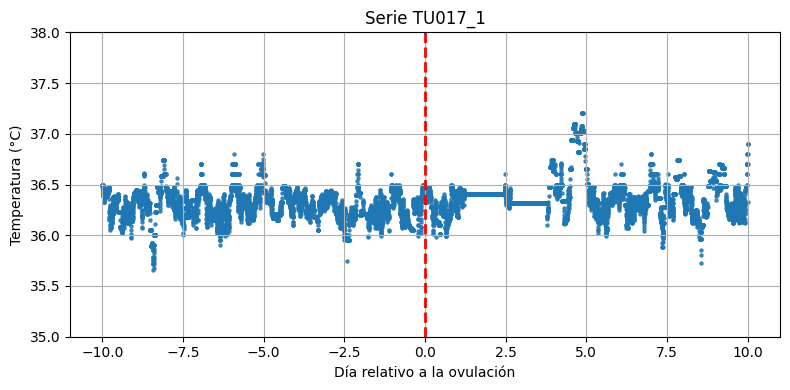

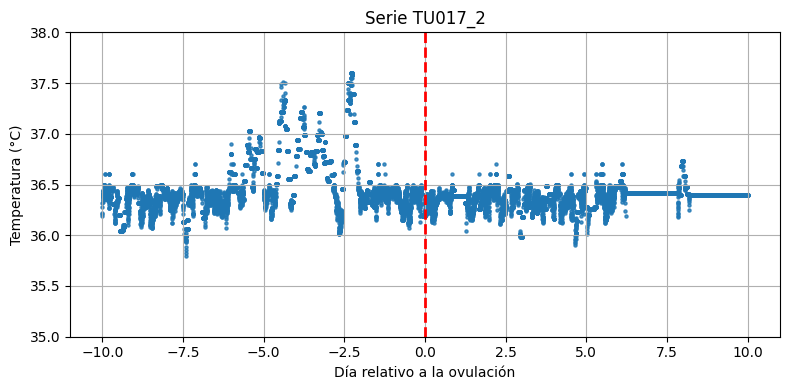

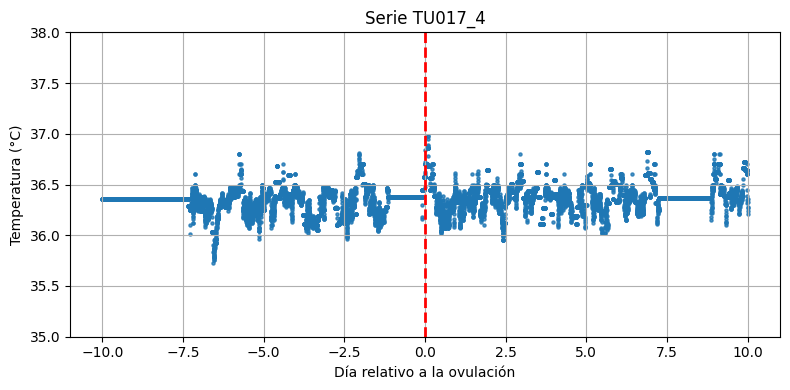

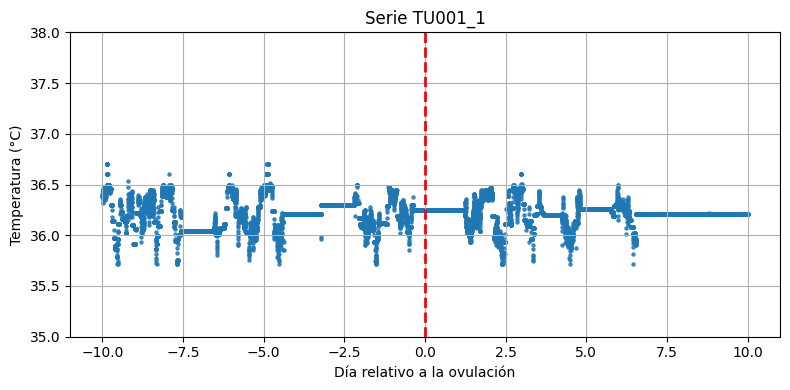

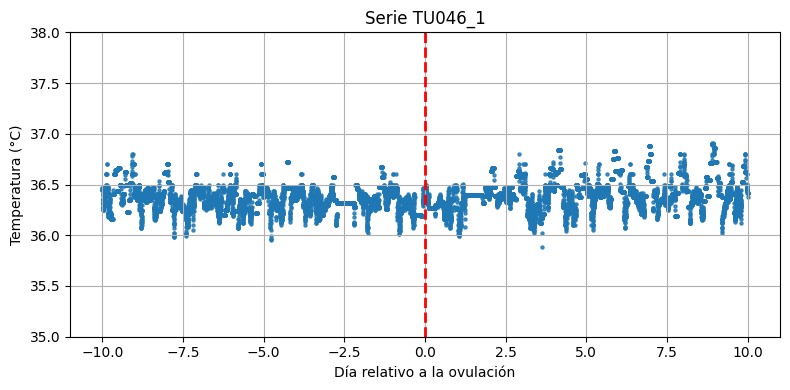

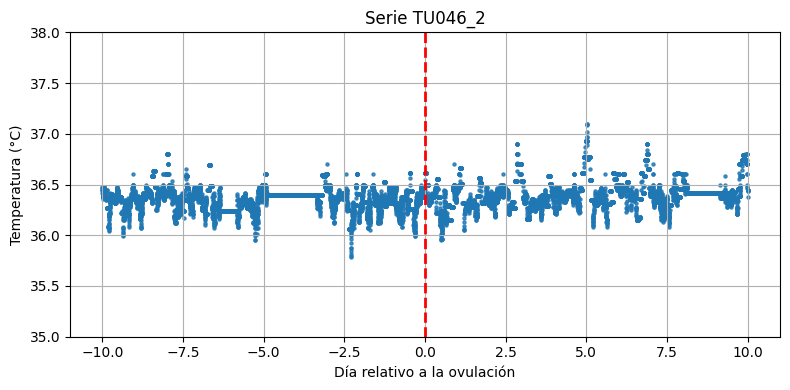

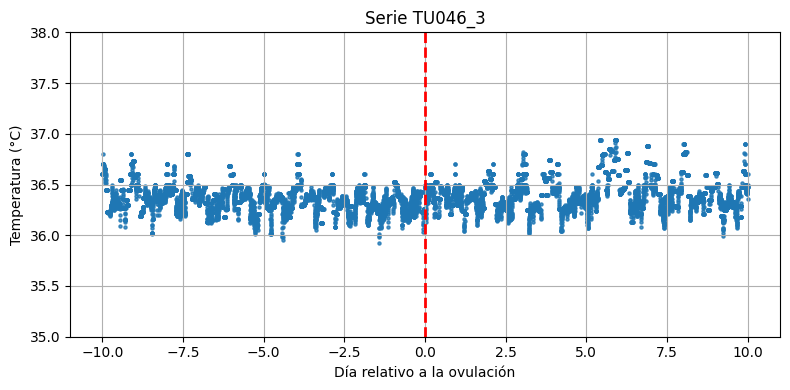

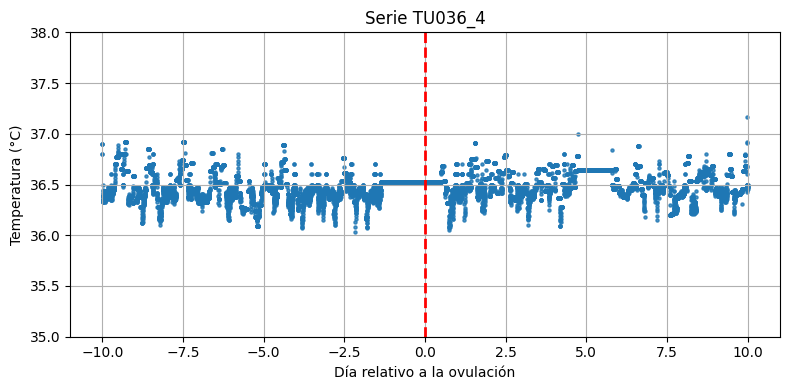

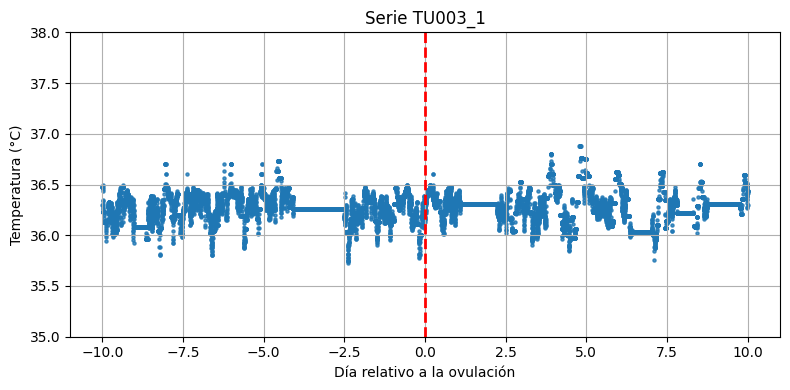

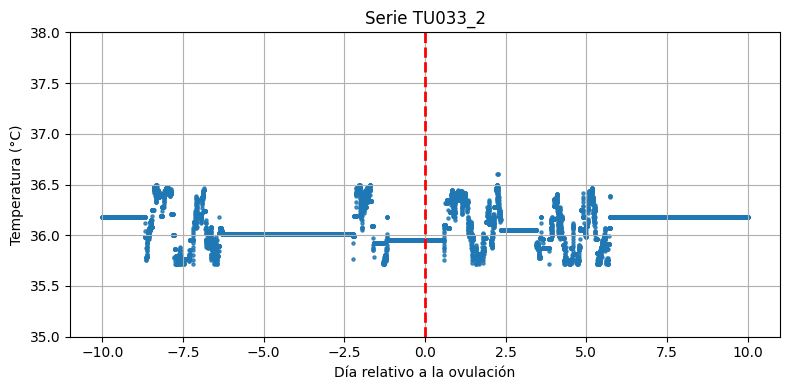

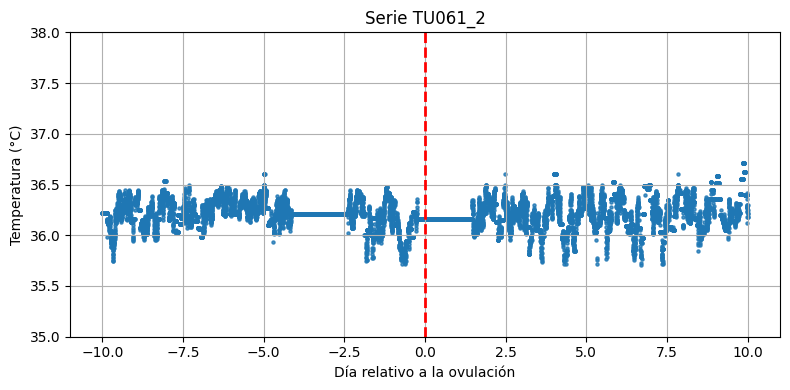

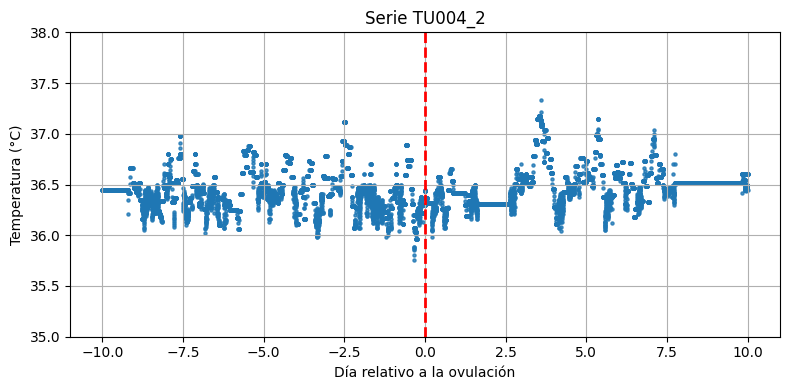

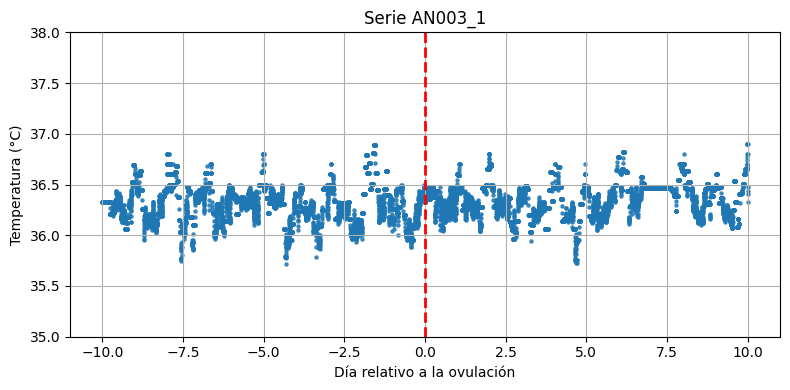

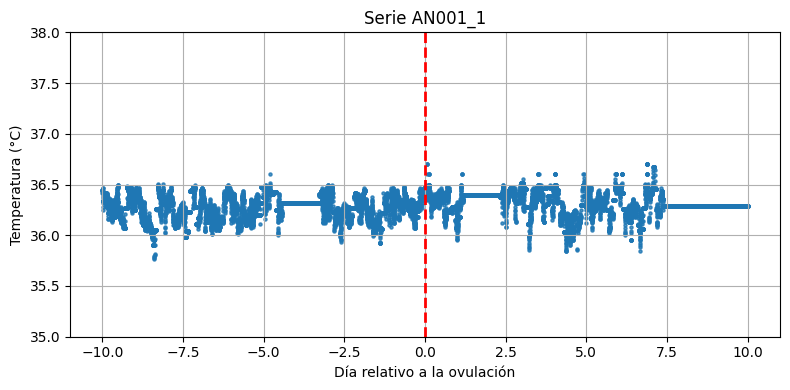

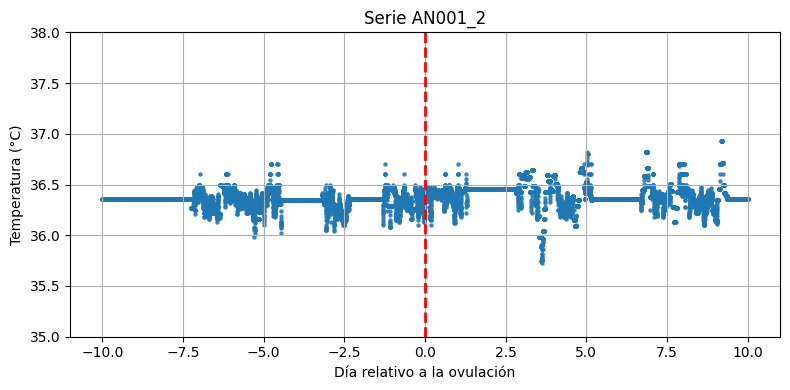

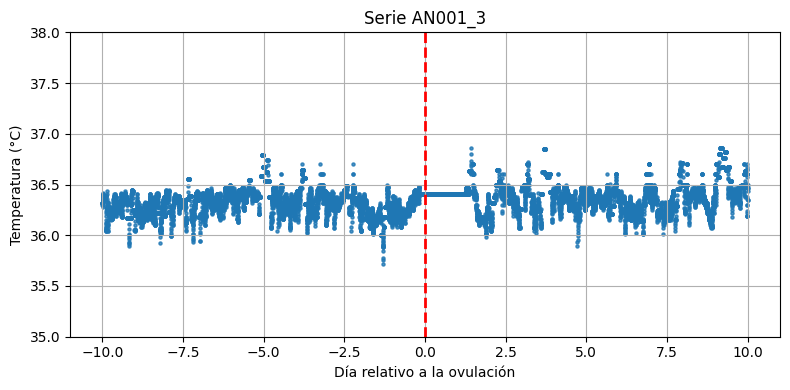

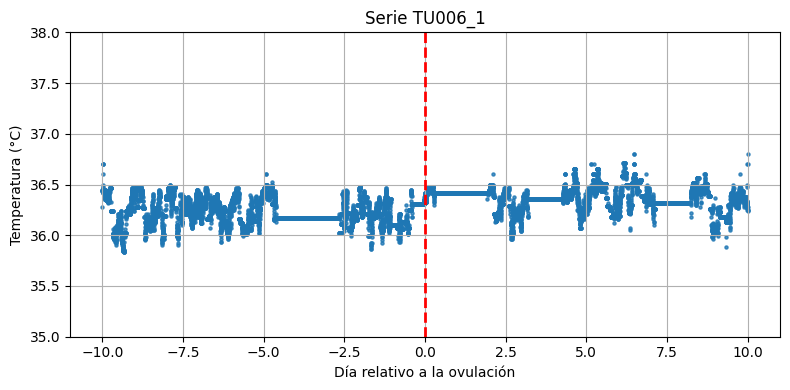

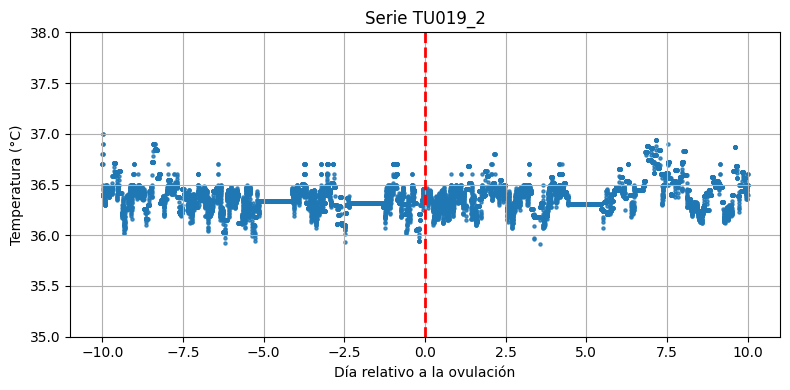

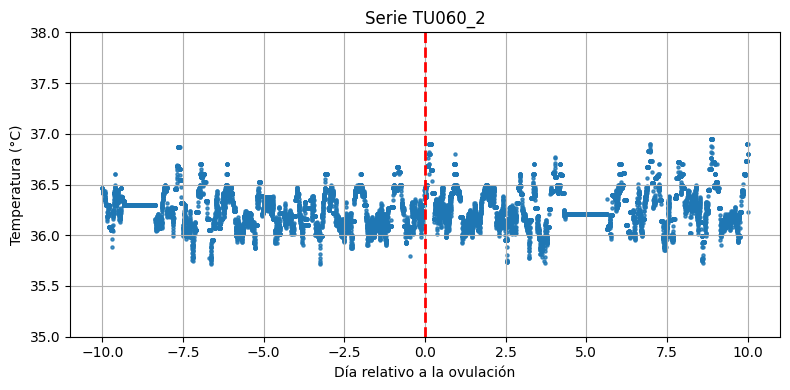

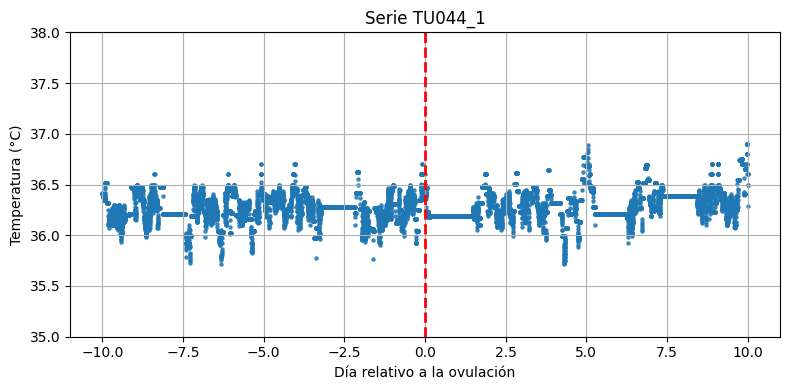

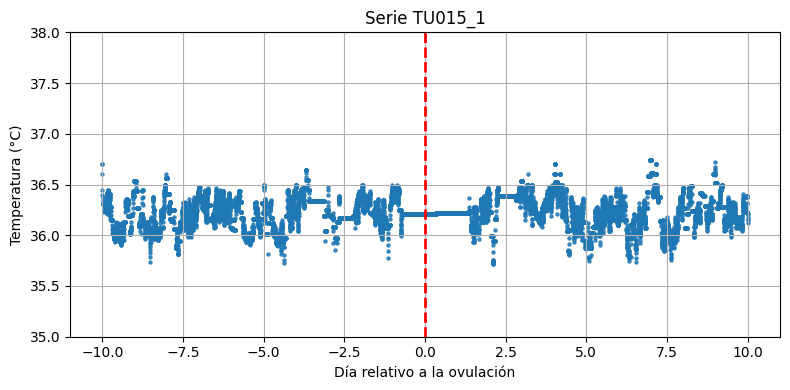

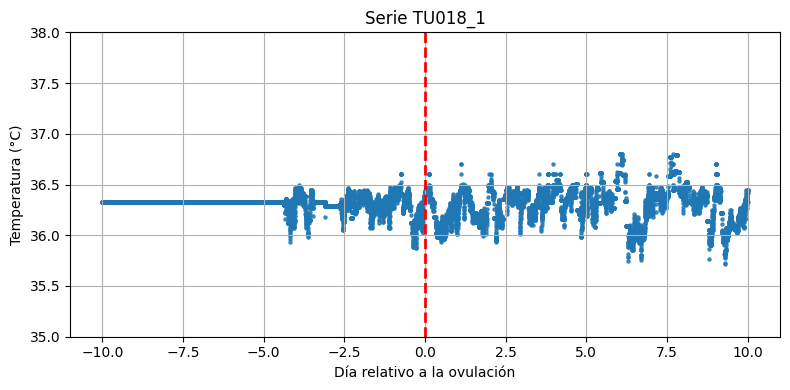

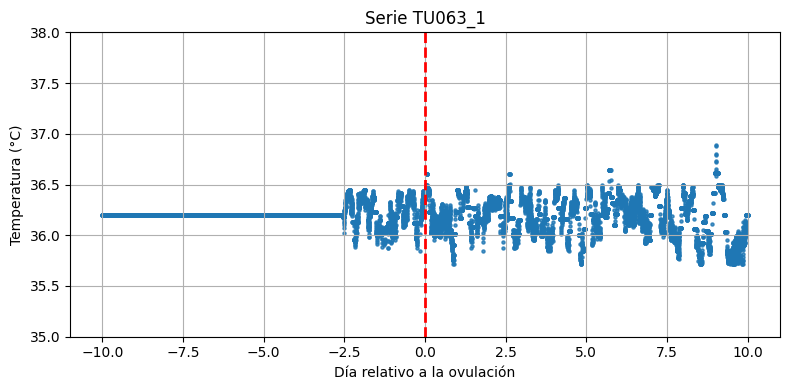

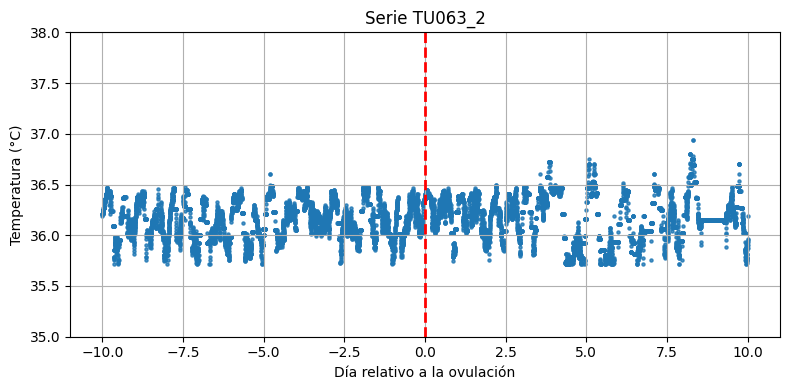

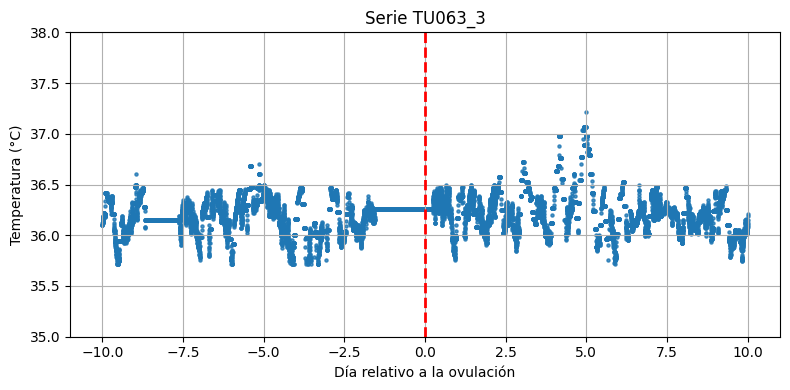

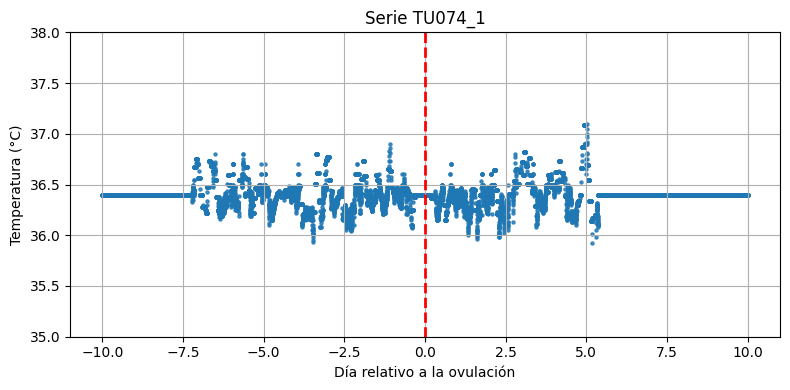

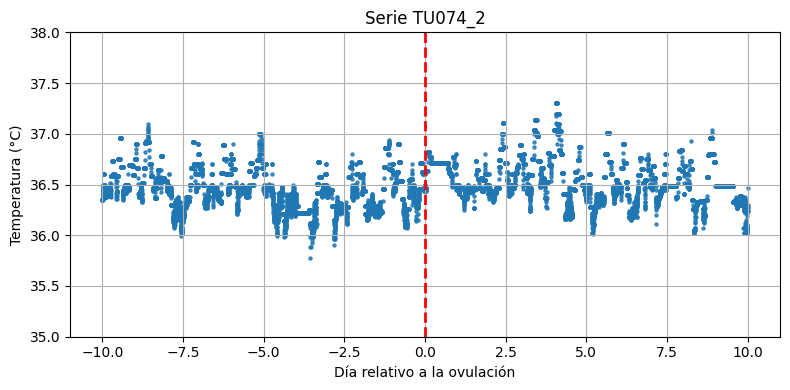

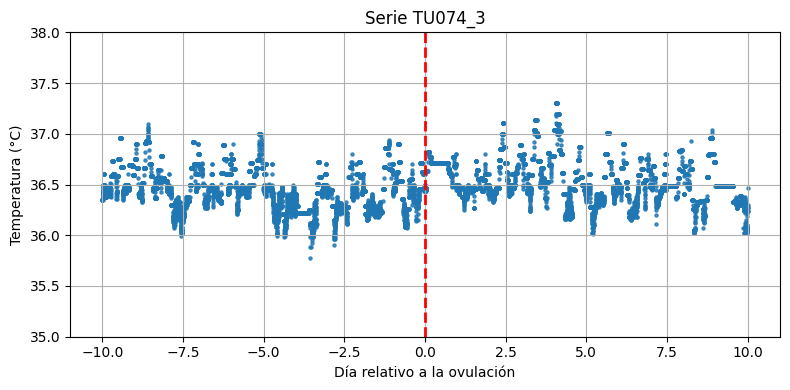

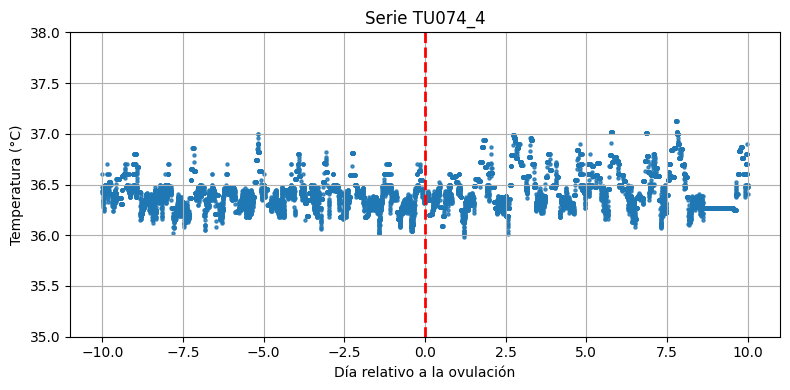

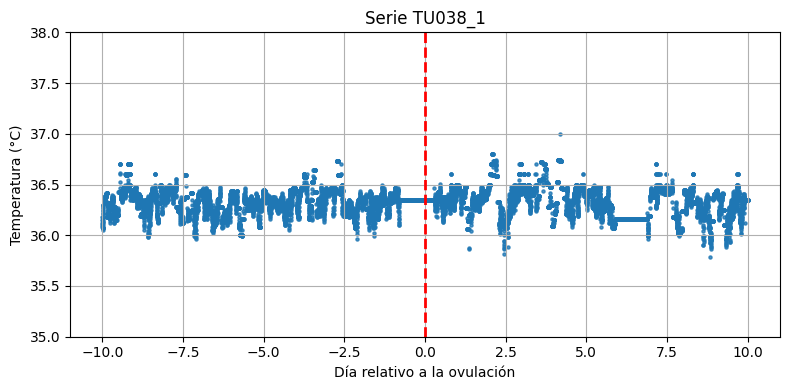

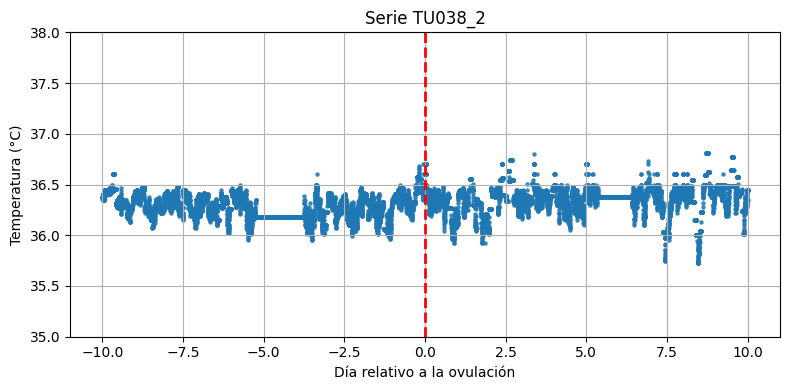

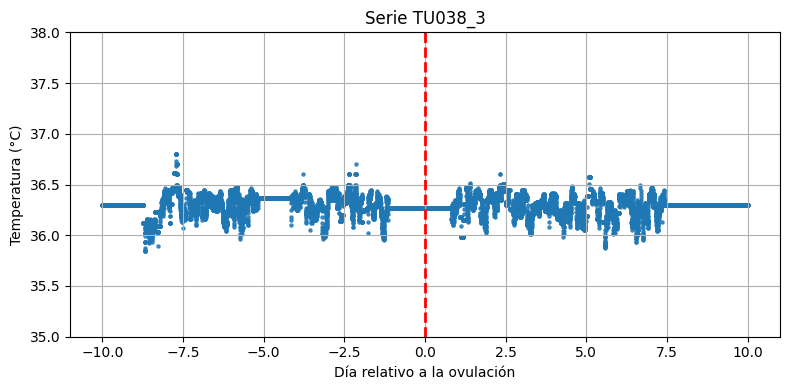

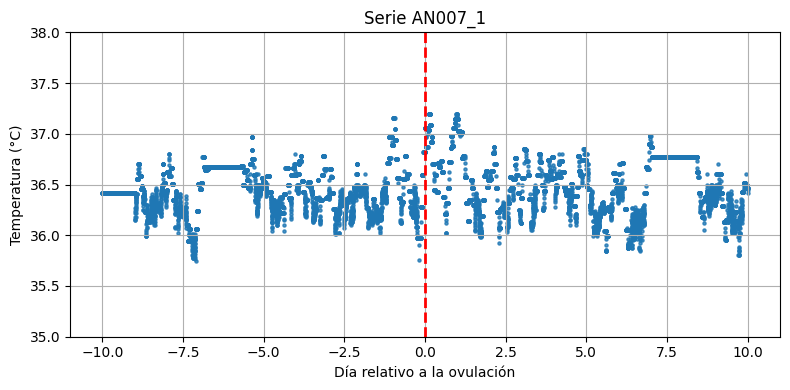

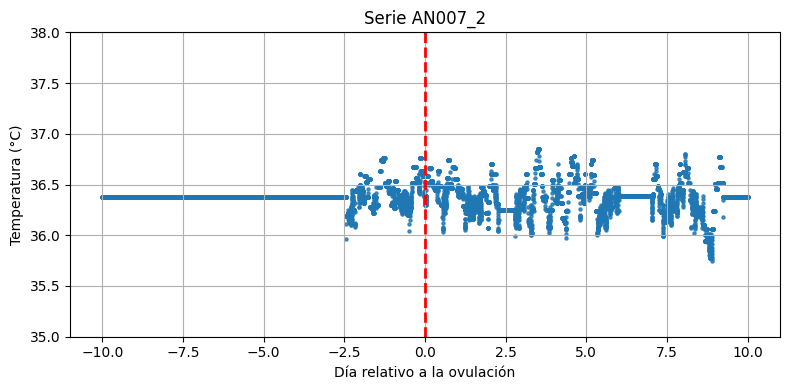

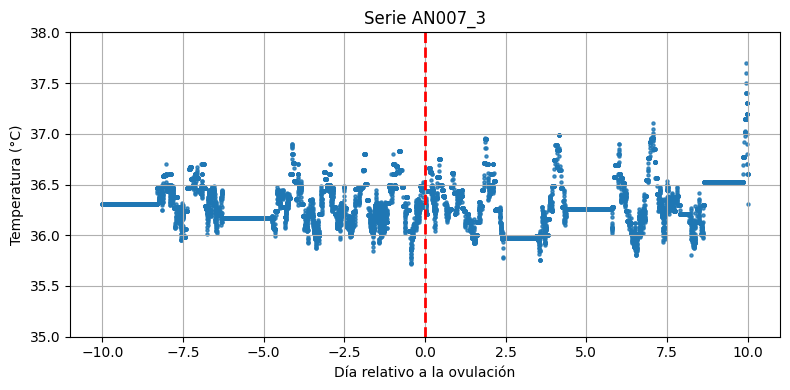

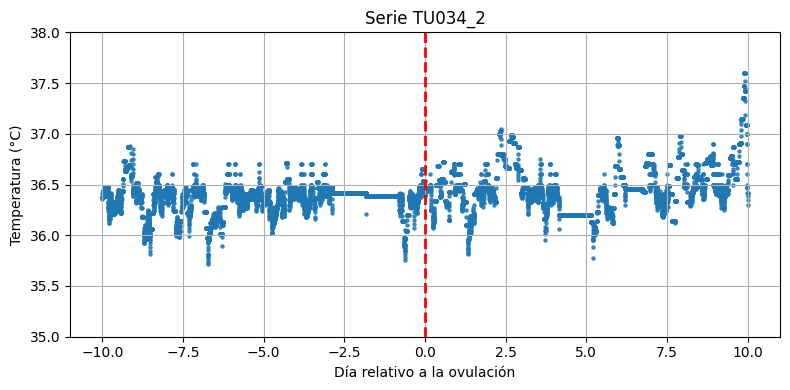

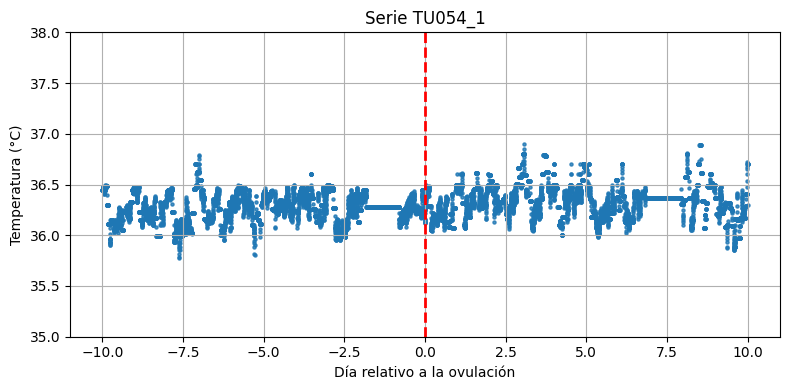

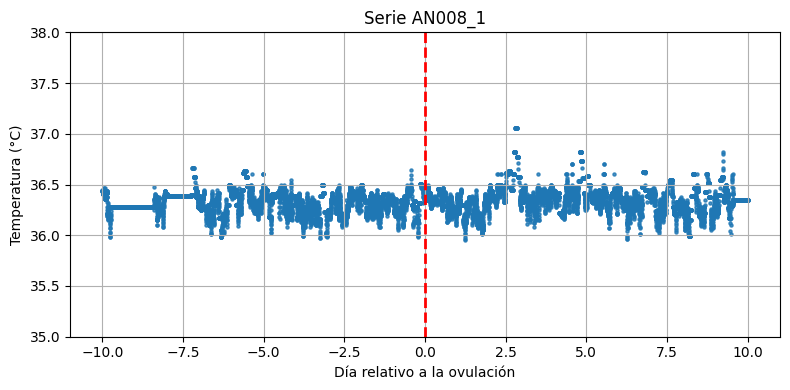

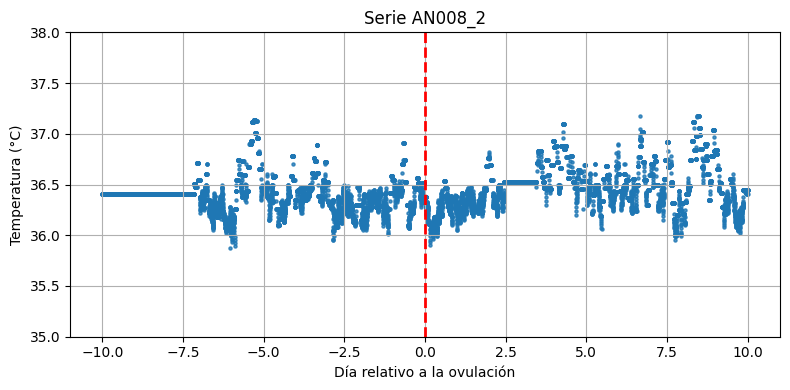

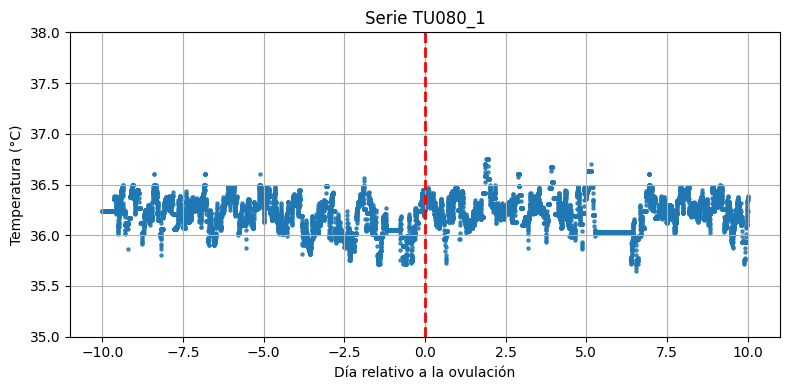

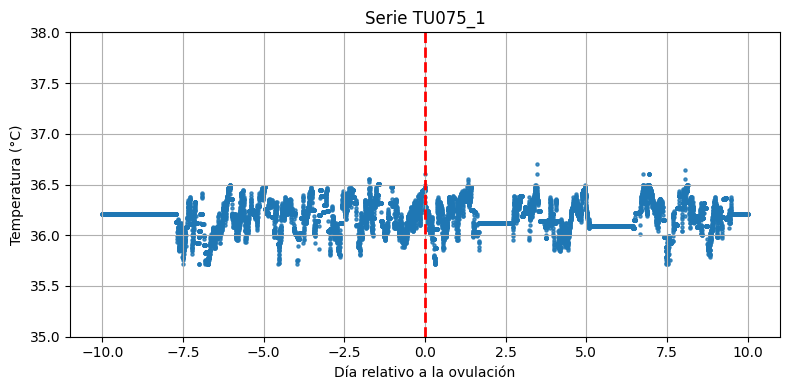

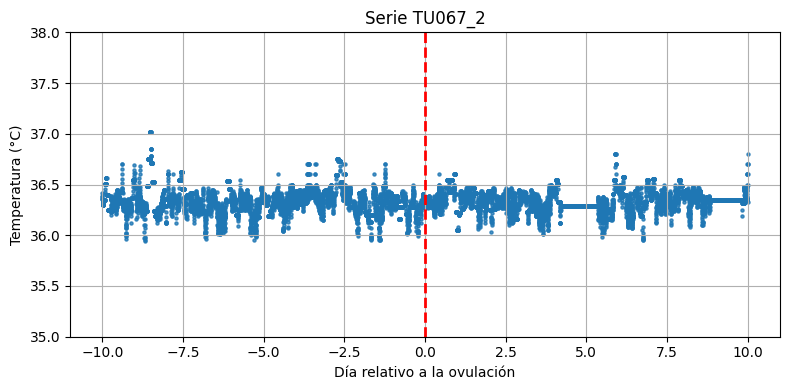

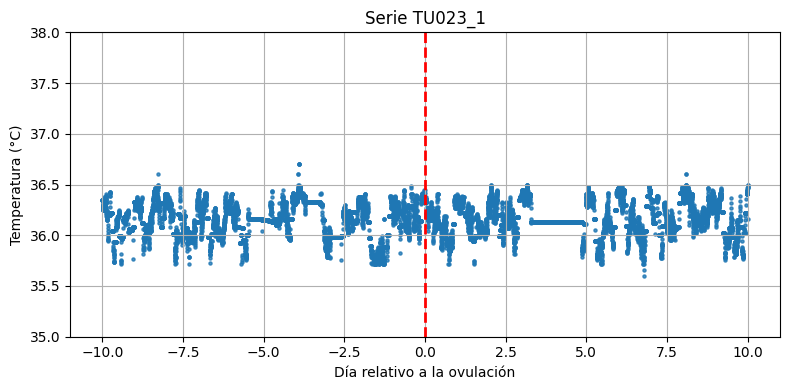

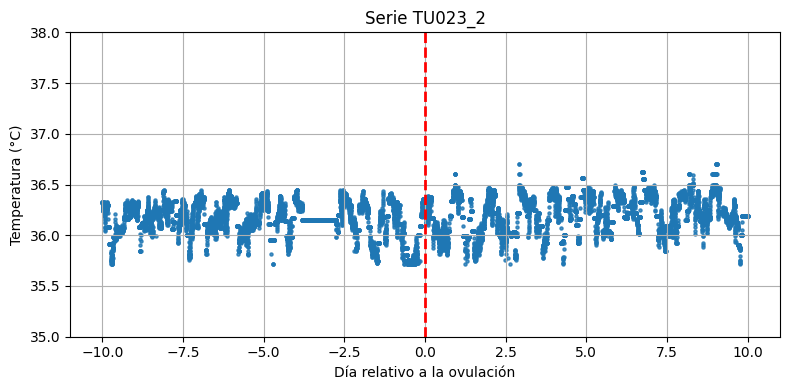

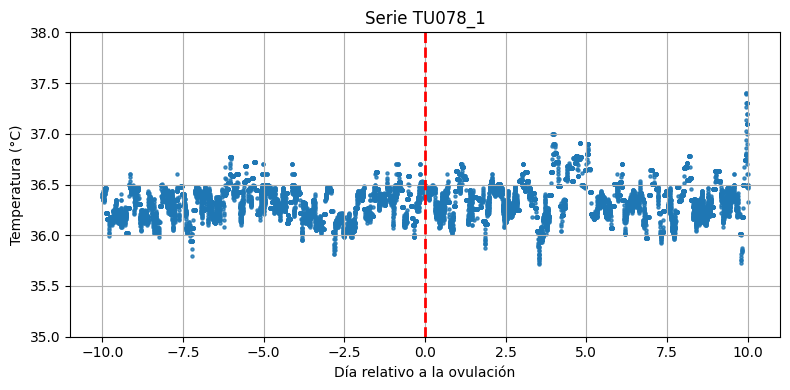

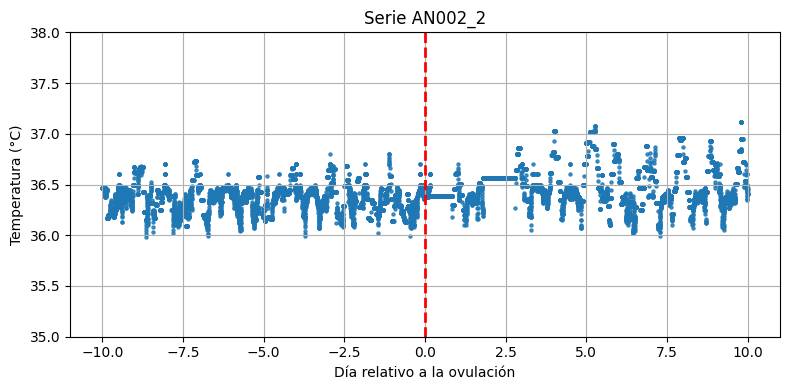

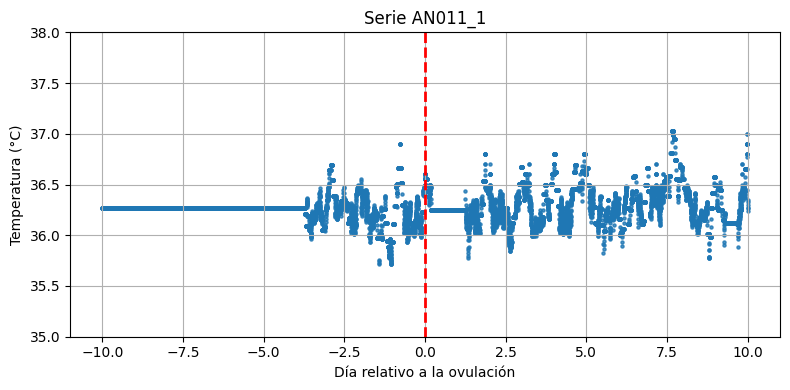

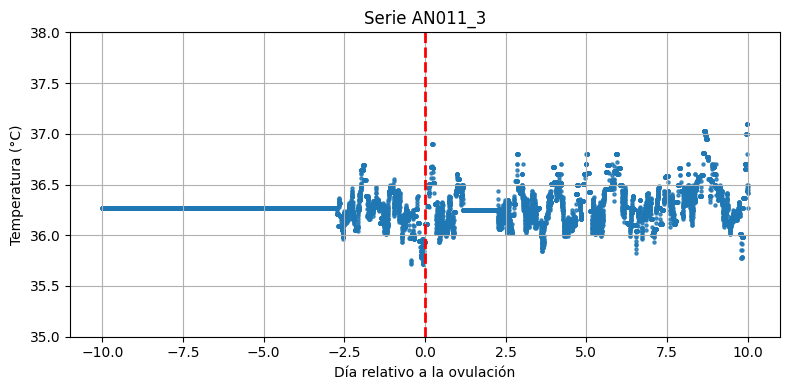

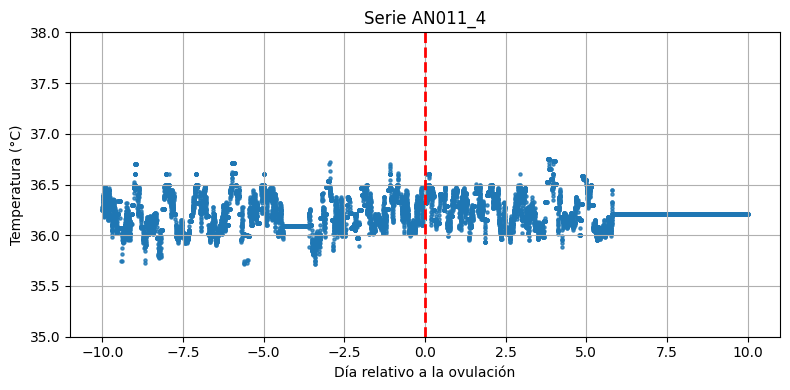

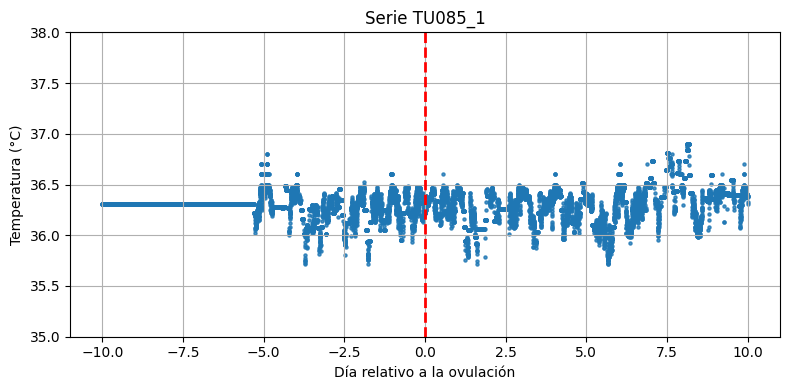

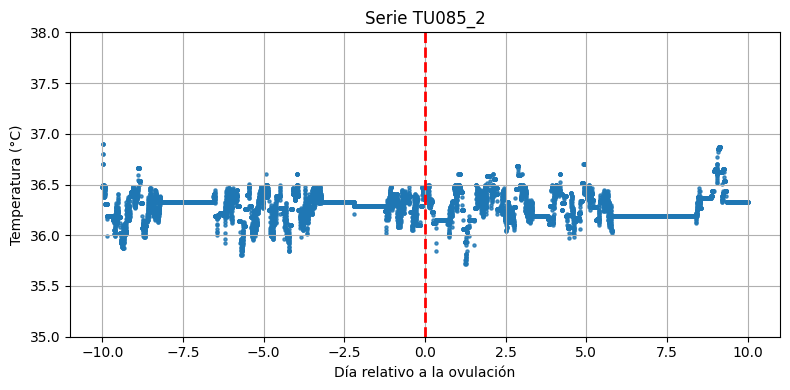

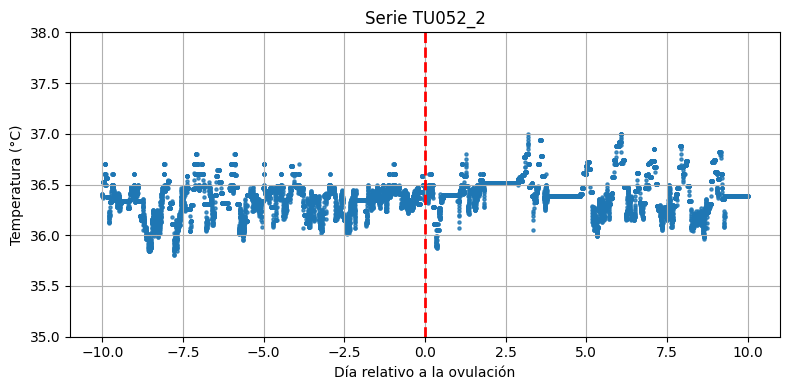

In [15]:
print_series(ids_series, muestras_imputadas_suavizadas)